In [9]:
#Mohsen Mohammadagha
import numpy as np

# Add this at the TOP of your code, before everything else
np.random.seed(42)  # Use any number you like

# Now your results will be identical every run!

class Layer:
    def forward(self, input):
        raise NotImplementedError
    def backward(self, grad_output):
        raise NotImplementedError

class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros((output_dim,))
    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.W.T) + self.b
        return self.output
    def backward(self, grad_output):
        self.dW = np.dot(grad_output.T, self.input)
        self.db = np.sum(grad_output, axis=0)
        grad_input = np.dot(grad_output, self.W)
        return grad_input
    def update_params(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

class Sigmoid(Layer):
    def forward(self, input):
        self.out = 1.0 / (1.0 + np.exp(-input))
        return self.out
    def backward(self, grad_output):
        sigmoid_grad = self.out * (1 - self.out)
        return grad_output * sigmoid_grad

class Tanh(Layer):
    def forward(self, input):
        self.out = np.tanh(input)
        return self.out
    def backward(self, grad_output):
        return grad_output * (1 - self.out ** 2)

class ReLU(Layer):
    def forward(self, input):
        self.input = input
        self.out = np.maximum(0, input)
        return self.out
    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input

class BinaryCrossEntropyLoss(Layer):
    def forward(self, predictions, targets):
        epsilon = 1e-12
        self.predictions = np.clip(predictions, epsilon, 1 - epsilon)
        self.targets = targets
        loss = - (targets * np.log(self.predictions) + (1 - targets) * np.log(1 - self.predictions))
        return np.mean(loss)
    def backward(self):
        epsilon = 1e-12
        grad = (-(self.targets) / (self.predictions + epsilon) +
                (1 - self.targets) / (1 - self.predictions + epsilon))
        grad = grad / self.targets.shape[0]
        return grad

class MSELoss(Layer):
    def forward(self, predictions, targets):
        self.predictions = predictions
        self.targets = targets
        loss = np.mean((predictions - targets) ** 2)
        return loss
    def backward(self):
        grad = 2 * (self.predictions - self.targets) / self.targets.shape[0]
        return grad

class Sequential(Layer):
    def __init__(self, layers):
        self.layers = layers
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output
    def update_params(self, learning_rate):
        for layer in self.layers:
            if hasattr(layer, 'update_params'):
                layer.update_params(learning_rate)
    def save_weights(self, filename):
        params = {}
        for idx, layer in enumerate(self.layers):
            if hasattr(layer, 'W'):
                params[f'layer_{idx}_W'] = layer.W
                params[f'layer_{idx}_b'] = layer.b
        np.savez(filename, **params)
    def load_weights(self, filename):
        data = np.load(filename)
        for idx, layer in enumerate(self.layers):
            if hasattr(layer, 'W'):
                layer.W = data[f'layer_{idx}_W']
                layer.b = data[f'layer_{idx}_b']

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

def train_xor(activation_type='sigmoid', epochs=10000, learning_rate=0.1):
    print(f"Training XOR with {activation_type} activation in the hidden layer.")
    X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
    ])
    y = np.array([[0], [1], [1], [0]])
    if activation_type == 'sigmoid':
        hidden_activation = Sigmoid()
    elif activation_type == 'tanh':
        hidden_activation = Tanh()
    else:
        raise ValueError("Unsupported activation type")
    model = Sequential([
        Linear(2, 2),
        hidden_activation,
        Linear(2, 1),
        Sigmoid()
    ])
    loss_fn = BinaryCrossEntropyLoss()
    for epoch in range(epochs):
        output = model.forward(X)
        loss = loss_fn.forward(output, y)
        grad_loss = loss_fn.backward()
        model.backward(grad_loss)
        model.update_params(learning_rate)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
        if loss < 0.01:
            print(f"Converged at epoch {epoch}, Loss: {loss:.4f}")
            break
    model.save_weights("XOR_solved.w")
    predictions = model.forward(X)
    print("Final Predictions on XOR input:")
    print(predictions)
    return model

def train_taxi():
    print("Training Taxi Trip Duration Model")
    data_path = 'nyc_taxi_data.npy'

    # Load the dataset
    dataset = np.load(data_path, allow_pickle=True).item()
    X_train, y_train = dataset["X_train"], dataset["y_train"]
    X_test, y_test = dataset["X_test"], dataset["y_test"]
    
    # 🔥 LIMIT DATA TO 800 TRAINING AND 200 TEST SAMPLES:
    X_train = X_train[:8000]    # Keep only first 800 training samples
    y_train = y_train[:8000]    # Keep only first 800 training labels
    X_test = X_test[:2000]      # Keep only first 200 test samples
    y_test = y_test[:2000]      # Keep only first 200 test labels
    
    # 🔧 FIX DATA TYPE ISSUES:
    # Convert pandas DataFrame to numpy array (numeric only)
    if hasattr(X_train, 'select_dtypes'):  # If it's pandas DataFrame
        print("Converting pandas DataFrame to numpy array...")
        X_train = X_train.select_dtypes(include=[np.number]).values
        X_test = X_test.select_dtypes(include=[np.number]).values
    
    # Ensure y arrays are numpy and proper shape
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    if hasattr(y_test, 'values'):
        y_test = y_test.values
        
    if len(y_train.shape) == 1:
        y_train = y_train.reshape(-1, 1)
    if len(y_test.shape) == 1:
        y_test = y_test.reshape(-1, 1)
    
    print(f"After conversion - X_train: {X_train.shape}, y_train: {y_train.shape}")
    print("Dataset Type:", type(dataset))
    print("X_train Shape:", np.shape(X_train))
    
    # 🔧 NORMALIZE TARGET VALUES (PREVENT EXPLODING GRADIENTS):
    print("Normalizing target values...")
    y_mean = y_train.mean()
    y_std = y_train.std() + 1e-6
    y_train_norm = (y_train - y_mean) / y_std
    y_test_norm = (y_test - y_mean) / y_std
    print(f"Y normalization - Mean: {y_mean:.2f}, Std: {y_std:.2f}")
    
    # Normalize the input data
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0) + 1e-6
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    
    # Split training data into train and validation
    split_idx = int(0.8 * X_train_norm.shape[0])
    X_train_split, y_train_split = X_train_norm[:split_idx], y_train_norm[:split_idx]
    X_val, y_val = X_train_norm[split_idx:], y_train_norm[split_idx:]
    
    # Create the neural network model
    input_dim = X_train_norm.shape[1]
    model = Sequential([
        Linear(input_dim, 100),
        ReLU(),
        Linear(100, 100),
        ReLU(),
        Linear(100, 1)  # Linear output for regression.
    ])
    
    # Training setup - 🔧 REDUCED LEARNING RATE TO PREVENT EXPLOSION
    loss_fn = MSELoss()
    epochs = 100
    learning_rate = 0.0001  # 🔥 REDUCED FROM 0.001 TO 0.0001
    best_val_loss = np.inf
    patience = 0
    
    print(f"Starting training with learning rate: {learning_rate}")
    
    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        predictions_train = model.forward(X_train_split)
        train_loss = loss_fn.forward(predictions_train, y_train_split)
        
        # Backward pass and parameter update
        grad_loss = loss_fn.backward()
        model.backward(grad_loss)
        
        # 🔧 GRADIENT CLIPPING TO PREVENT EXPLOSION:
        for layer in model.layers:
            if hasattr(layer, 'dW'):
                layer.dW = np.clip(layer.dW, -1, 1)
                layer.db = np.clip(layer.db, -1, 1)
        
        model.update_params(learning_rate)
        
        # Validation
        predictions_val = model.forward(X_val)
        val_loss = loss_fn.forward(predictions_val, y_val)
        
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            
        if patience >= 10:  # Increased patience
            print("Early stopping triggered")
            break
            
        # Safety check - stop if loss becomes too large
        if train_loss > 1e6 or np.isnan(train_loss) or np.isinf(train_loss):
            print("Training unstable - stopping early")
            break
    
    # Final evaluation on test set
    predictions_test = model.forward(X_test_norm)
    test_loss = loss_fn.forward(predictions_test, y_test_norm)
    
    # Denormalize predictions for RMSLE calculation
    predictions_test_denorm = predictions_test * y_std + y_mean
    y_test_denorm = y_test  # Original test values
    
    # Ensure positive values for RMSLE (trip durations should be positive)
    predictions_test_denorm = np.maximum(predictions_test_denorm, 0.1)
    y_test_denorm = np.maximum(y_test_denorm, 0.1)
    
    test_rmsle = rmsle(y_test_denorm, predictions_test_denorm)
    print(f"Test MSE Loss (normalized): {test_loss:.4f}")
    print(f"Test RMSLE (denormalized): {test_rmsle:.4f}")
    
    # Show some sample predictions
    print("\nSample predictions (denormalized):")
    for i in range(min(5, len(predictions_test_denorm))):
        pred = predictions_test_denorm[i, 0]
        actual = y_test_denorm[i, 0]
        print(f"Predicted: {pred:.2f}, Actual: {actual:.2f}")
    
    return model

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description="Neural Network Library Assignment")
    parser.add_argument("--task", choices=["xor", "taxi"], default="xor",
                        help="Task to run: 'xor' for the XOR problem, 'taxi' for taxi trip duration prediction")
    parser.add_argument("--activation", choices=["sigmoid", "tanh"], default="sigmoid",
                        help="Activation function for the hidden layer in the XOR model")
    args, unknown = parser.parse_known_args()
    if args.task == "xor":
        train_xor(activation_type=args.activation)
    elif args.task == "taxi":
        train_taxi()

# 🔥 RUN THE TAXI TRAINING AUTOMATICALLY
train_taxi()

Training XOR with sigmoid activation in the hidden layer.
Epoch 0, Loss: 0.7065
Epoch 1000, Loss: 0.6826
Epoch 2000, Loss: 0.6043
Epoch 3000, Loss: 0.4713
Epoch 4000, Loss: 0.1989
Epoch 5000, Loss: 0.0804
Epoch 6000, Loss: 0.0469
Epoch 7000, Loss: 0.0325
Epoch 8000, Loss: 0.0247
Epoch 9000, Loss: 0.0198
Final Predictions on XOR input:
[[0.01920235]
 [0.98500294]
 [0.98506176]
 [0.01652386]]
Training Taxi Trip Duration Model
Converting pandas DataFrame to numpy array...
After conversion - X_train: (8000, 6), y_train: (8000, 1)
Dataset Type: <class 'dict'>
X_train Shape: (8000, 6)
Normalizing target values...
Y normalization - Mean: 933.66, Std: 2918.02
Starting training with learning rate: 0.0001
Epoch 0, Train Loss: 1.2654, Val Loss: 1.4357
Epoch 1, Train Loss: 1.2630, Val Loss: 1.4333
Epoch 2, Train Loss: 1.2606, Val Loss: 1.4309
Epoch 3, Train Loss: 1.2582, Val Loss: 1.4285
Epoch 4, Train Loss: 1.2558, Val Loss: 1.4262
Epoch 5, Train Loss: 1.2535, Val Loss: 1.4239
Epoch 6, Train Loss

In [3]:
import numpy as np
data = np.load('nyc_taxi_data.npy', allow_pickle=True).item()

total_numbers = 0
for name, array in data.items():
    count = array.size  # Total numbers in this array
    total_numbers += count
    print(f"{name}: {array.shape} = {count} numbers")
    
print(f"Total numbers in file: {total_numbers}")


X_train: (1312779, 10) = 13127790 numbers
X_test: (145865, 10) = 1458650 numbers
y_train: (1312779,) = 1312779 numbers
y_test: (145865,) = 145865 numbers
Total numbers in file: 16045084


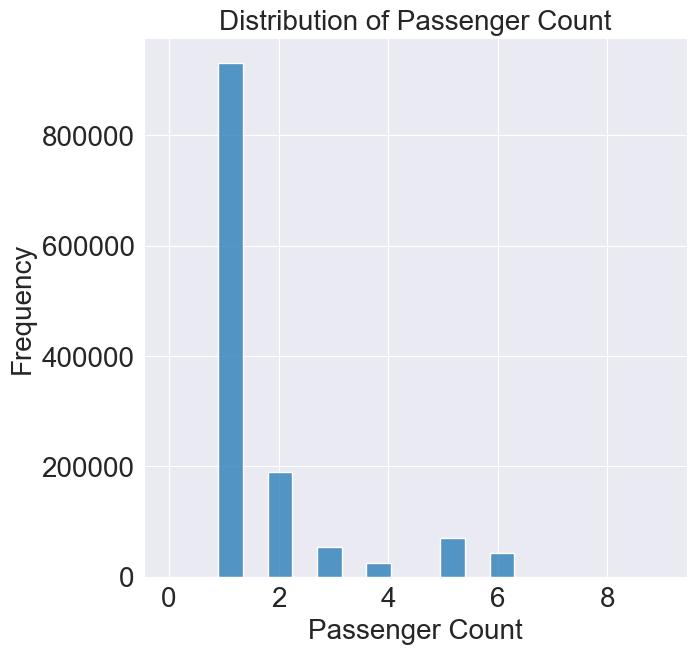

Number of training samples: 1312779
Number of features: 10
Number of test samples: 145865


In [1]:
#dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
import numpy as np
import seaborn as sns

sns.set_style("white")        # White background, no grid
sns.set_style("whitegrid")    # White background, gray grid
sns.set_style("darkgrid")     # Gray background, white grid (current default)

# from google.colab import drive # mount Drive
# drive.mount('/content/drive') # approve prompt
# dataset = np.load('drive/MyDrive/nyc_taxi_data.npy', allow_pickle=True).item()
dataset = np.load('nyc_taxi_data.npy', allow_pickle=True).item()


df = dataset["X_train"]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 7))  # Width=10", Height=6"


sns.histplot(df['passenger_count'], bins=20)
plt.title('Distribution of Passenger Count', fontsize=20)
plt.xlabel('Passenger Count', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Adjust tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

print(f"Number of training samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

print(f"Number of test samples: {dataset['X_test'].shape[0]}")


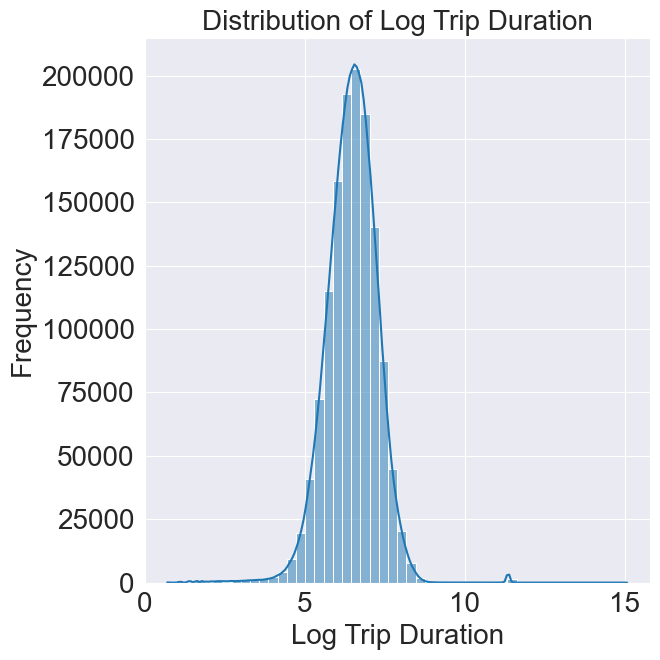

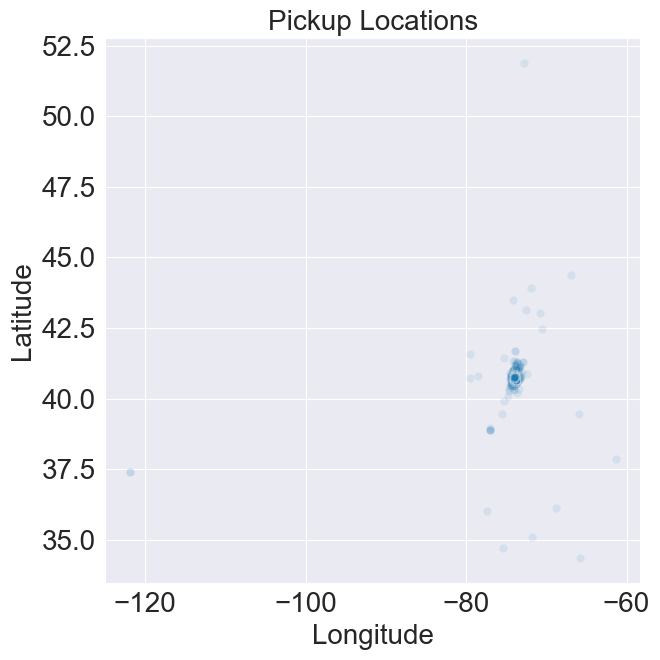

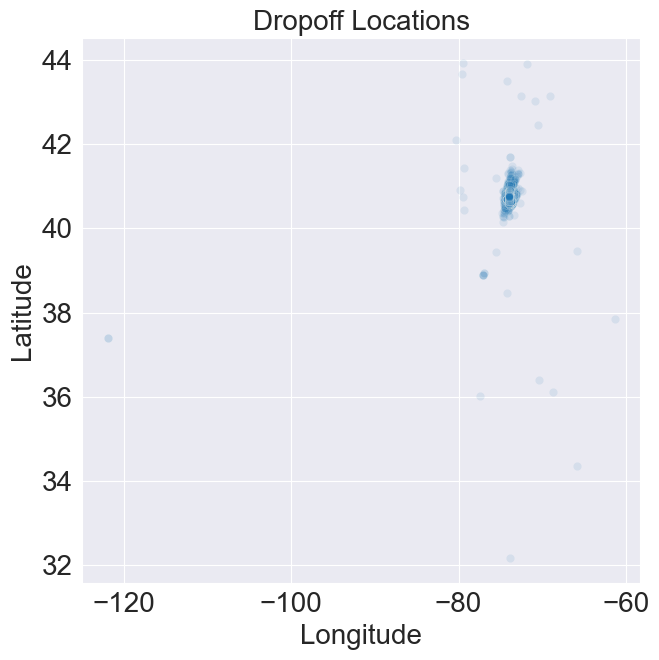

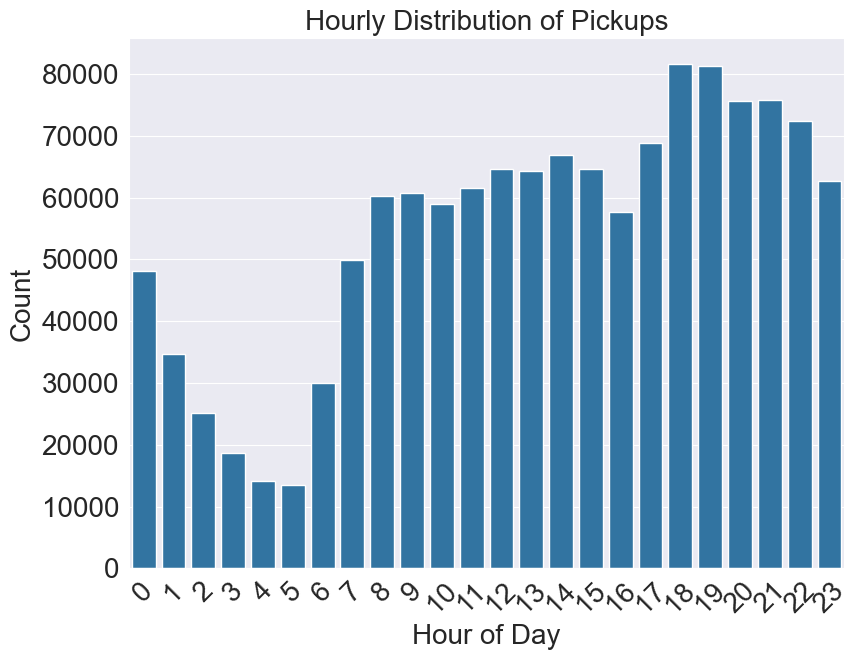

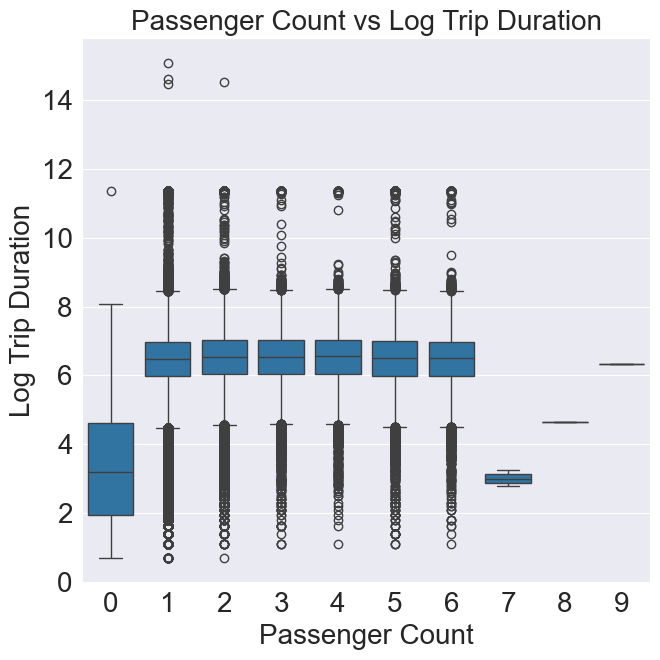

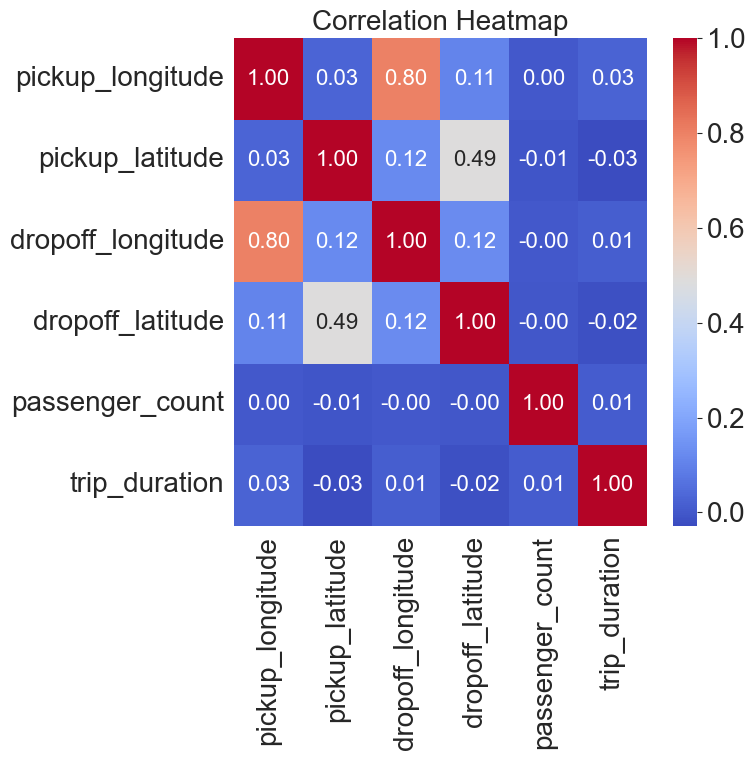

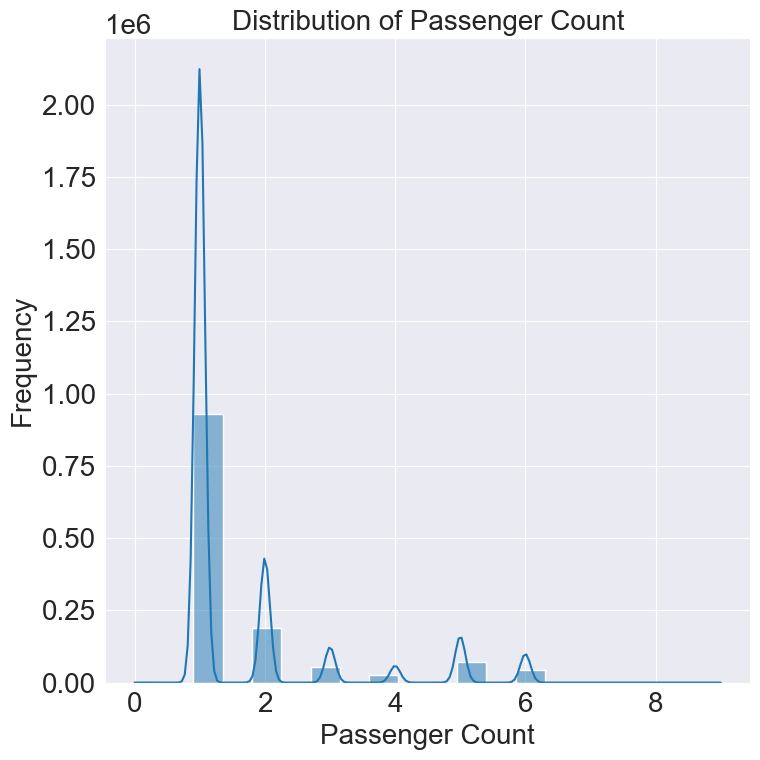

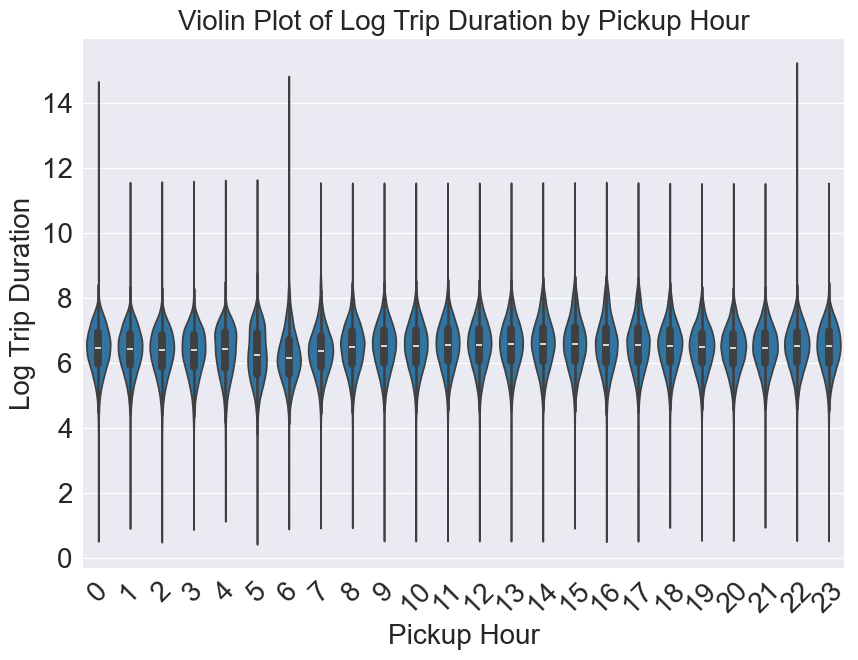

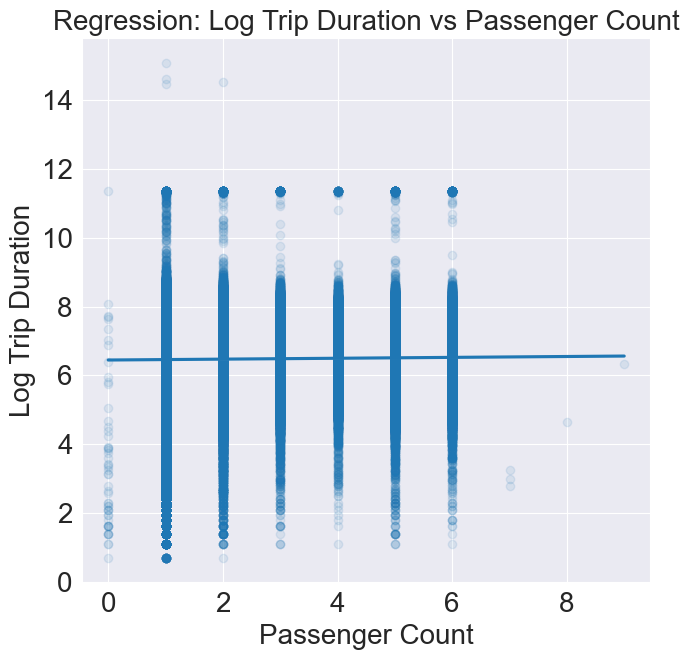

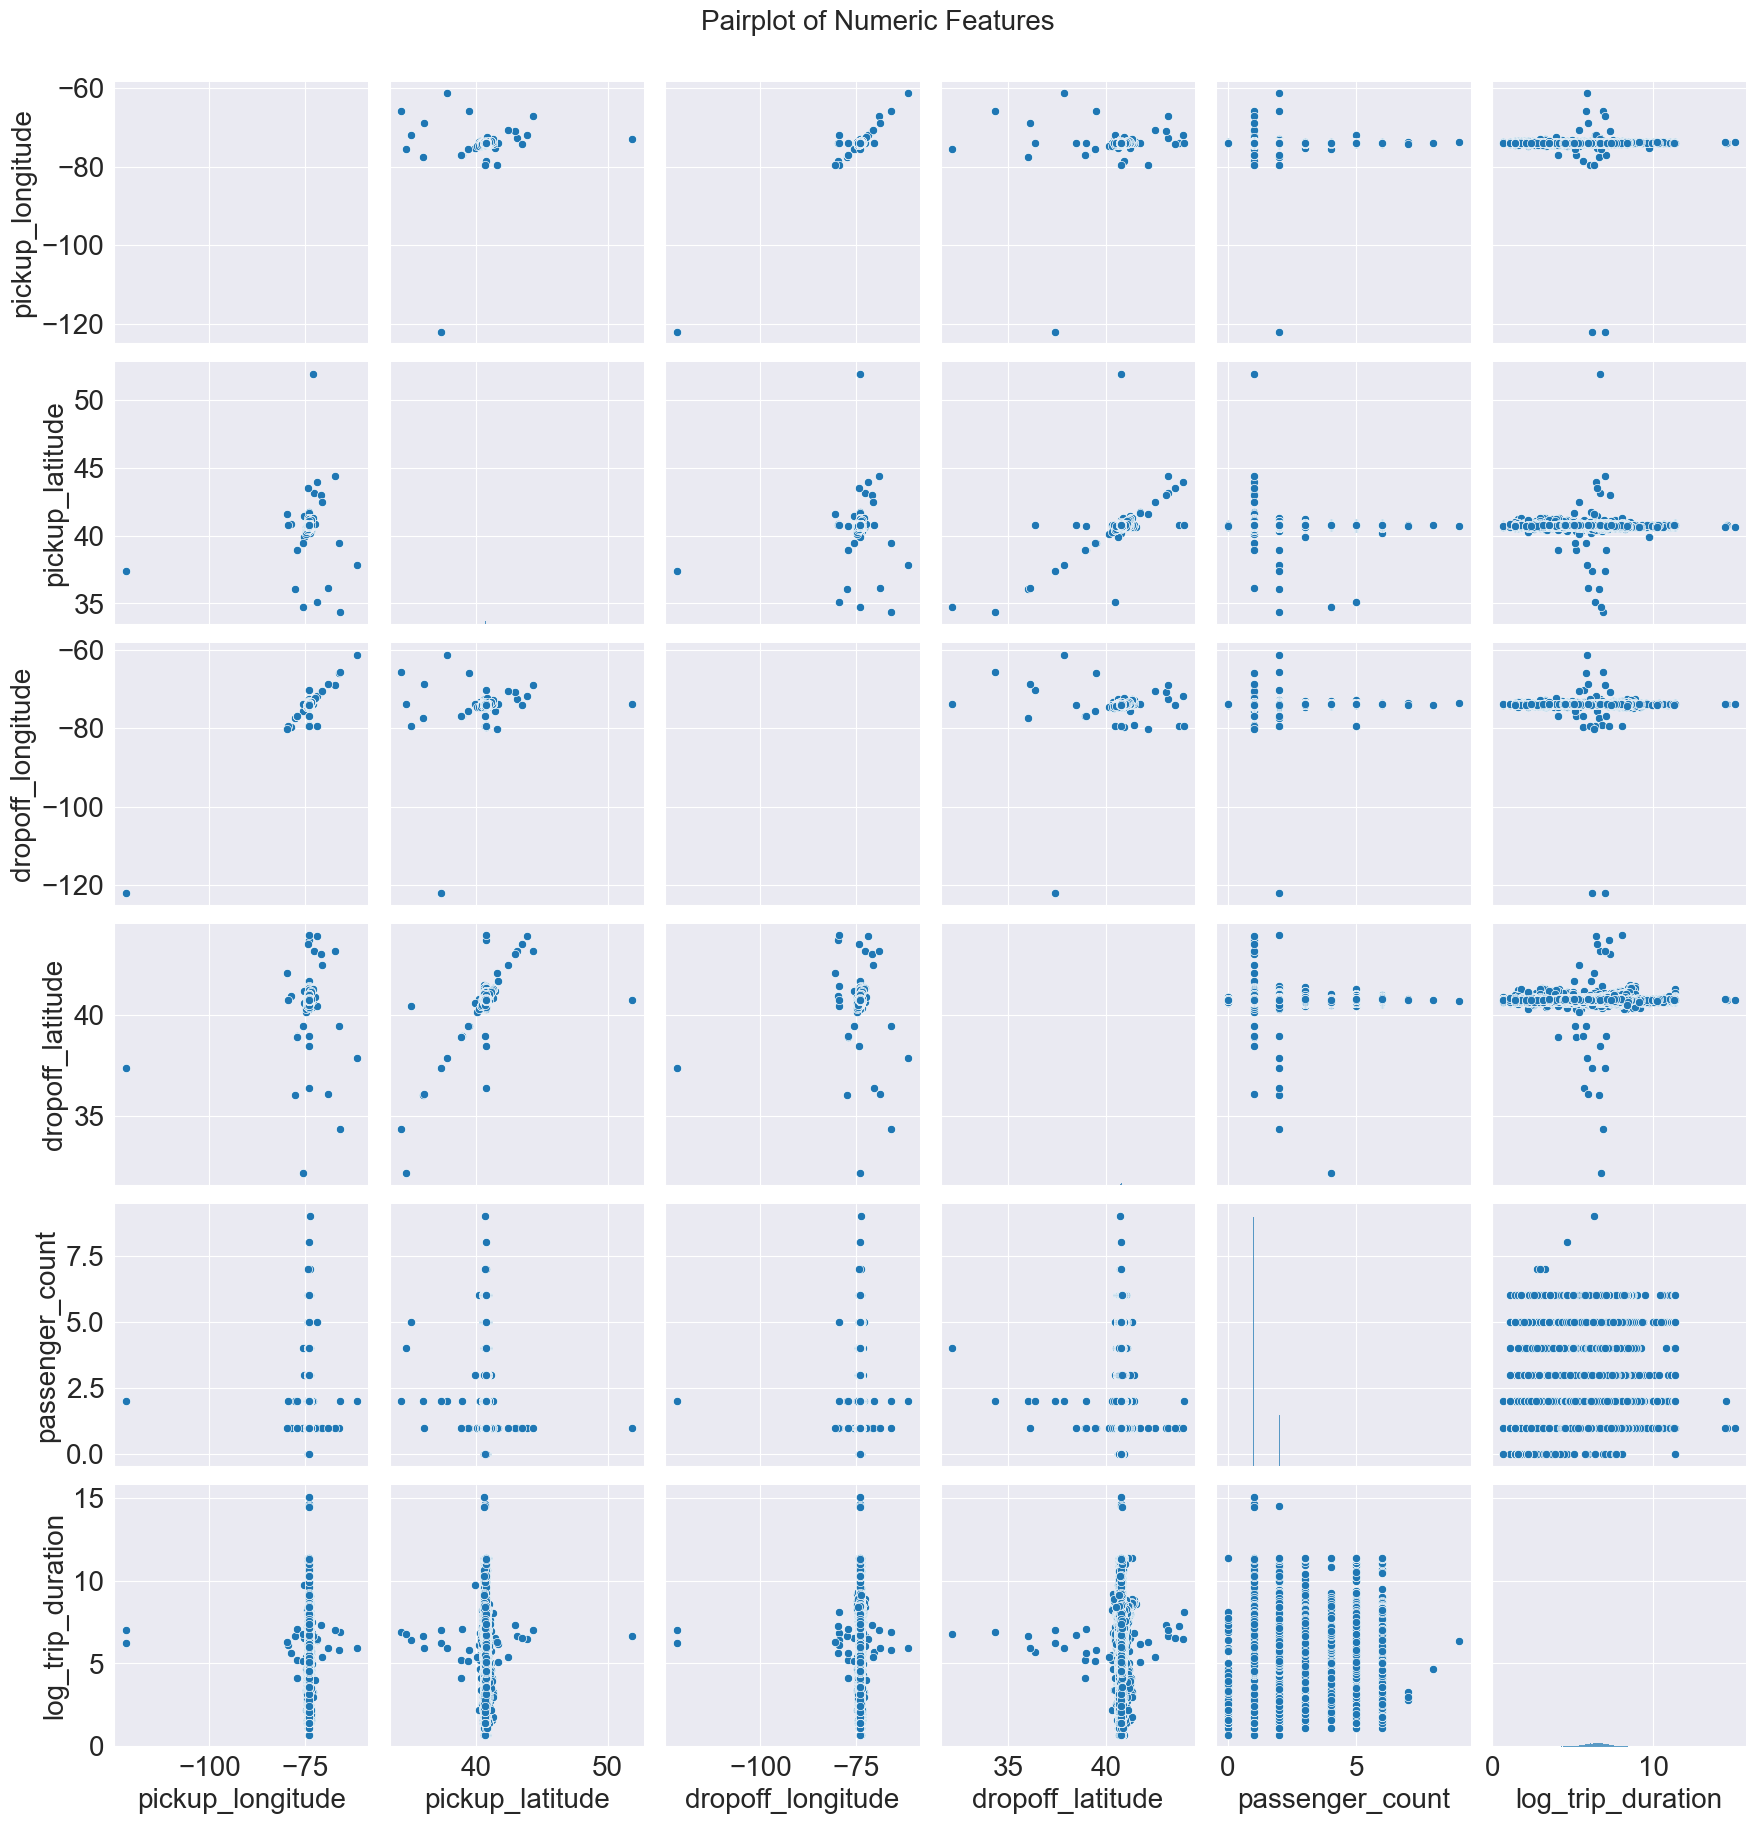

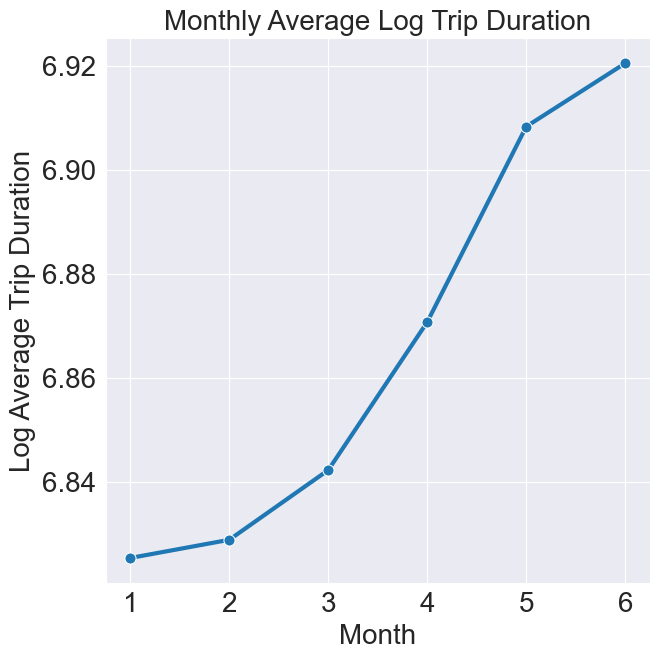

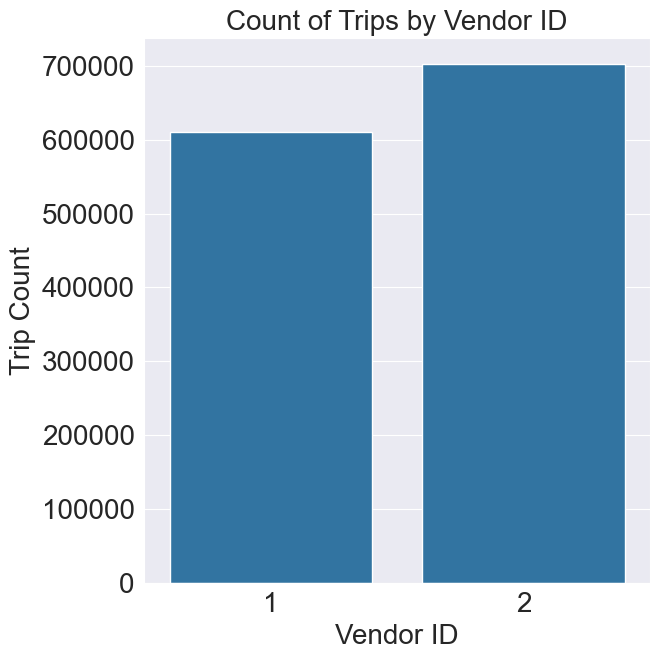

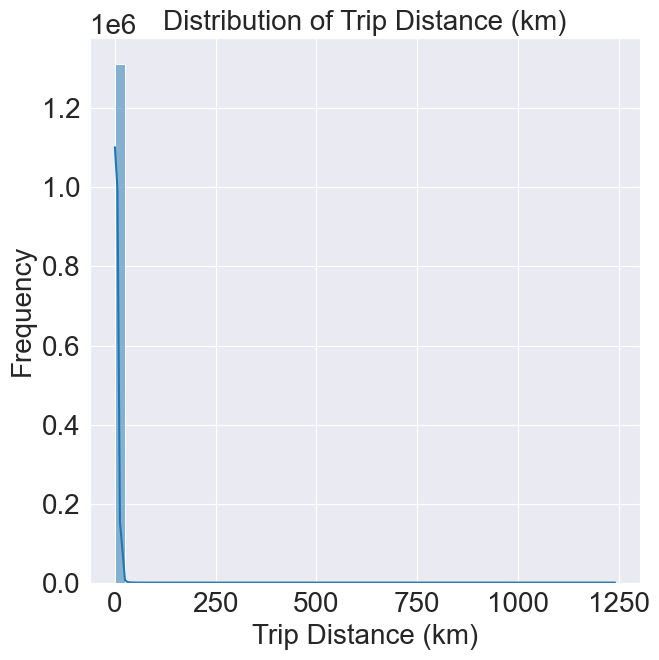

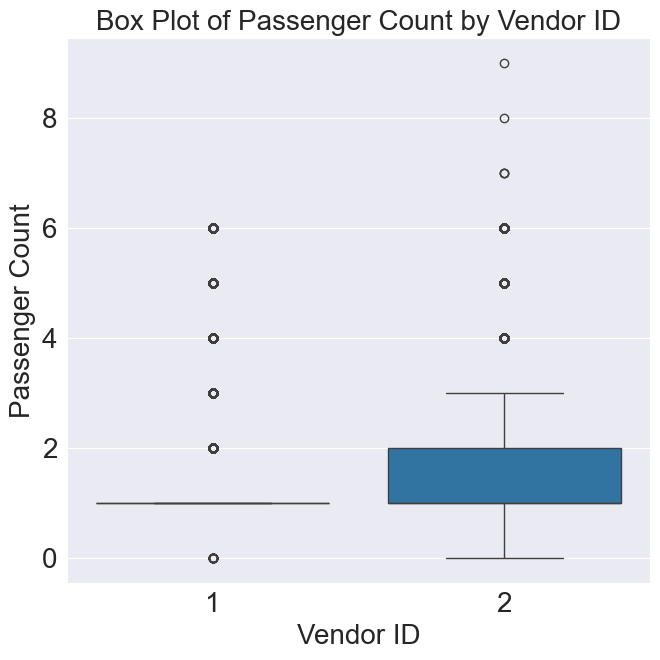

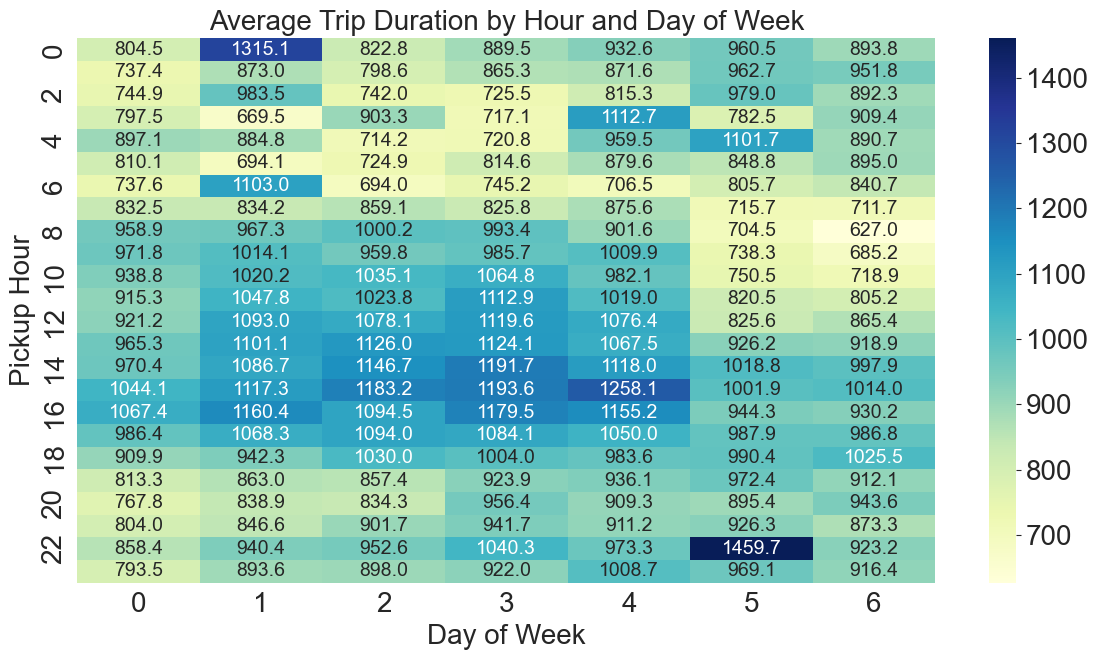


Table 1: Summary Statistics for Numeric Columns
       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      1.312779e+06     1.312779e+06       1.312779e+06      1.312779e+06   
mean      -7.397350e+01     4.075093e+01      -7.397342e+01      4.075181e+01   
std        7.351224e-02     3.291198e-02       7.316118e-02      3.579324e-02   
min       -1.219333e+02     3.435970e+01      -1.219333e+02      3.218114e+01   
25%       -7.399187e+01     4.073735e+01      -7.399133e+01      4.073589e+01   
50%       -7.398174e+01     4.075410e+01      -7.397975e+01      4.075453e+01   
75%       -7.396734e+01     4.076835e+01      -7.396302e+01      4.076980e+01   
max       -6.133553e+01     5.188108e+01      -6.133553e+01      4.392103e+01   

       passenger_count  trip_duration  trip_distance  
count     1.312779e+06   1.312779e+06   1.312779e+06  
mean      1.664126e+00   9.589538e+02   3.440868e+00  
std       1.313950e+00   5.409679e+03   4.302587e+00  
m

In [6]:
#copy of 1th for font 20

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style("white")        # White background, no grid
sns.set_style("whitegrid")    # White background, gray grid
sns.set_style("darkgrid")     # Gray background, white grid (current default)


# Set global font parameters for all plots
plt.rcParams.update({
    'font.size': 20,          # Base font size
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 20,     # Axis label font size
    'xtick.labelsize': 20,    # X-axis tick label size
    'ytick.labelsize': 20,    # Y-axis tick label size
    'legend.fontsize': 20,    # Legend font size
    'figure.titlesize': 20    # Figure title font size
})

# from google.colab import drive # mount Drive
# drive.mount('/content/drive') # approve prompt
# dataset = np.load('drive/MyDrive/nyc_taxi_data.npy', allow_pickle=True).item()

dataset = np.load('nyc_taxi_data.npy', allow_pickle=True).item()
df = dataset["X_train"]

data_path = "nyc_taxi_data.npy"
# dataset = np.load(data_path, allow_pickle=True).item()

df = dataset["X_train"]
df = pd.DataFrame(df)
y_train = dataset["y_train"]
df = df.copy()     # avoid SettingWithCopyWarning
df["trip_duration"] = y_train  # trip duration in seconds
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["pickup_day"] = df["pickup_datetime"].dt.dayofweek  # Monday=0, Sunday=6
df["pickup_month"] = df["pickup_datetime"].dt.month

plt.figure(figsize=(7, 7))  # Increased figure size for better visibility with larger fonts
sns.histplot(np.log1p(df["trip_duration"]), bins=50, kde=True)
plt.title('Distribution of Log Trip Duration')
plt.xlabel('Log Trip Duration')
plt.ylabel('Frequency')
plt.tight_layout()  # Ensure labels don't get cut off
plt.show()

plt.figure(figsize=(7, 7))
sns.scatterplot(x=df['pickup_longitude'], y=df['pickup_latitude'], alpha=0.1)
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
sns.scatterplot(x=df['dropoff_longitude'], y=df['dropoff_latitude'], alpha=0.1)
plt.title('Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 7 ))  # Extra width for 24 hour labels
sns.countplot(x=df['pickup_hour'], order=range(24))
plt.title('Hourly Distribution of Pickups')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
sns.boxplot(x=df['passenger_count'], y=np.log1p(df['trip_duration']))
plt.title('Passenger Count vs Log Trip Duration')
plt.xlabel('Passenger Count')
plt.ylabel('Log Trip Duration')
plt.tight_layout()
plt.show()

numeric_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'trip_duration']
df_numeric = df[numeric_cols]
corr_matrix = df_numeric.corr()
plt.figure(figsize=(8, 8))  # Square aspect ratio for heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 16})  # Annotation font size
plt.title('Correlation Heatmap')

# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
sns.histplot(df['passenger_count'], bins=20, kde=True)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 7))  # Extra width for violin plot
sns.violinplot(x=df['pickup_hour'], y=np.log1p(df['trip_duration']))
plt.title('Violin Plot of Log Trip Duration by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Log Trip Duration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
sns.regplot(x=df['passenger_count'], y=np.log1p(df['trip_duration']), scatter_kws={'alpha':0.1})
plt.title('Regression: Log Trip Duration vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Log Trip Duration')
plt.tight_layout()
plt.show()

df_pairplot = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'trip_duration']].copy()
df_pairplot['log_trip_duration'] = np.log1p(df_pairplot['trip_duration'])
# For pairplot, create with larger figure size
# sns.set(font_scale=1.5)  # Increase font scale for pairplot
g = sns.pairplot(df_pairplot.drop(columns=['trip_duration']), height=3)
g.fig.suptitle('Pairplot of Numeric Features', y=1.02, fontsize=20)
plt.show()
# sns.set(font_scale=1)  # Reset font scale

monthly_avg = df.groupby('pickup_month')['trip_duration'].mean()
plt.figure(figsize=(7, 7))
sns.lineplot(x=monthly_avg.index, y=np.log1p(monthly_avg.values), marker='o', markersize=8, linewidth=3)
plt.title('Monthly Average Log Trip Duration')
plt.xlabel('Month')
plt.ylabel('Log Average Trip Duration')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
vendor_counts = df['vendor_id'].value_counts()
sns.barplot(x=vendor_counts.index, y=vendor_counts.values)
plt.title('Count of Trips by Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Trip Count')
plt.tight_layout()
plt.show()

# Calculate trip distance using Haversine formula
R = 6371  # Radius of the earth in km
lat1 = np.radians(df['pickup_latitude'])
lon1 = np.radians(df['pickup_longitude'])
lat2 = np.radians(df['dropoff_latitude'])
lon2 = np.radians(df['dropoff_longitude'])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))
df['trip_distance'] = R * c

plt.figure(figsize=(7, 7))
sns.histplot(df['trip_distance'], bins=50, kde=True)
plt.title('Distribution of Trip Distance (km)')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
sns.boxplot(x=df['vendor_id'], y=df['passenger_count'])
plt.title('Box Plot of Passenger Count by Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Passenger Count')
plt.tight_layout()
plt.show()

heatmap_data = df.groupby(['pickup_hour', 'pickup_day'])['trip_duration'].mean().unstack()
plt.figure(figsize=(12, 7 ))  # Larger size for detailed heatmap
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f", annot_kws={'size': 14})
plt.title('Average Trip Duration by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Pickup Hour')
plt.tight_layout()
plt.show()

# Print tables (these will use the console font settings)
print("\nTable 1: Summary Statistics for Numeric Columns")
print(df[numeric_cols + ['trip_distance']].describe())

print("\nTable 2: Frequency Count for Vendor ID")
vendor_freq = df['vendor_id'].value_counts().to_frame(name='count')
print(vendor_freq)

print("\nTable 3: Average Trip Duration by Vendor ID")
avg_duration_vendor = df.groupby('vendor_id')['trip_duration'].mean().to_frame(name='avg_trip_duration')
print(avg_duration_vendor)

print("\nTable 4: Average Trip Duration by Pickup Hour")
avg_duration_hour = df.groupby('pickup_hour')['trip_duration'].mean().to_frame(name='avg_trip_duration')
print(avg_duration_hour)

print("\nTable 5: Average Trip Duration by Pickup Day of Week")
avg_duration_day = df.groupby('pickup_day')['trip_duration'].mean().to_frame(name='avg_trip_duration')
print(avg_duration_day)

print("\nTable 6: Average Trip Distance by Pickup Hour")
avg_distance_hour = df.groupby('pickup_hour')['trip_distance'].mean().to_frame(name='avg_trip_distance')
print(avg_distance_hour)

print("\nTable 7: Pivot Table – Average Trip Duration by Vendor ID and Pickup Hour")
pivot_table = df.pivot_table(values='trip_duration', index='vendor_id', columns='pickup_hour', aggfunc='mean')
print(pivot_table)

print("\nTable 8: Count of Trips by Month")
trip_counts_month = df.groupby('pickup_month')['trip_duration'].count().to_frame(name='trip_count')
print(trip_counts_month)

print("\nTable 9: Aggregated Statistics for Passenger Count by Vendor ID")
passenger_stats = df.groupby('vendor_id')['passenger_count'].agg(['mean', 'median', 'std', 'min', 'max'])
print(passenger_stats)

print("\nTable 10: Correlation Table for Selected Numeric Features")
print(corr_matrix)


Training samples loaded: 1,312,779
Test samples loaded: 145,865
Total samples: 1,458,644
Training features sample:
                id  vendor_id      pickup_datetime     dropoff_datetime  \
879655   id2425795          1  2016-01-08 23:55:11  2016-01-09 00:04:32   
646838   id0767831          2  2016-03-05 09:52:06  2016-03-05 10:00:12   
1138713  id0449104          1  2016-04-09 16:03:53  2016-04-09 16:21:22   
864716   id3030157          1  2016-01-06 11:12:44  2016-01-06 11:19:49   
434927   id1584885          1  2016-06-26 09:10:56  2016-06-26 09:17:44   

         passenger_count  pickup_longitude  pickup_latitude  \
879655                 1        -73.955551        40.773346   
646838                 1        -73.962181        40.763599   
1138713                1        -73.977486        40.751842   
864716                 1        -73.970001        40.762363   
434927                 1        -73.950348        40.771561   

         dropoff_longitude  dropoff_latitude store_and_

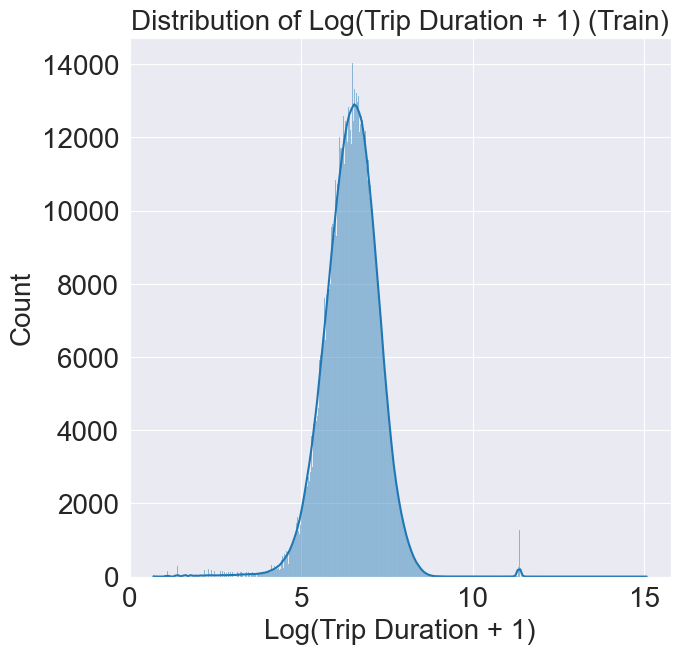

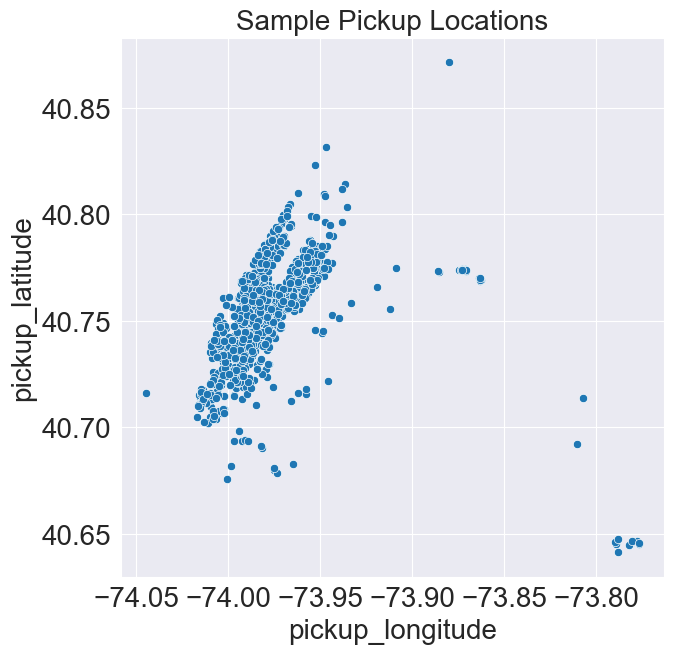

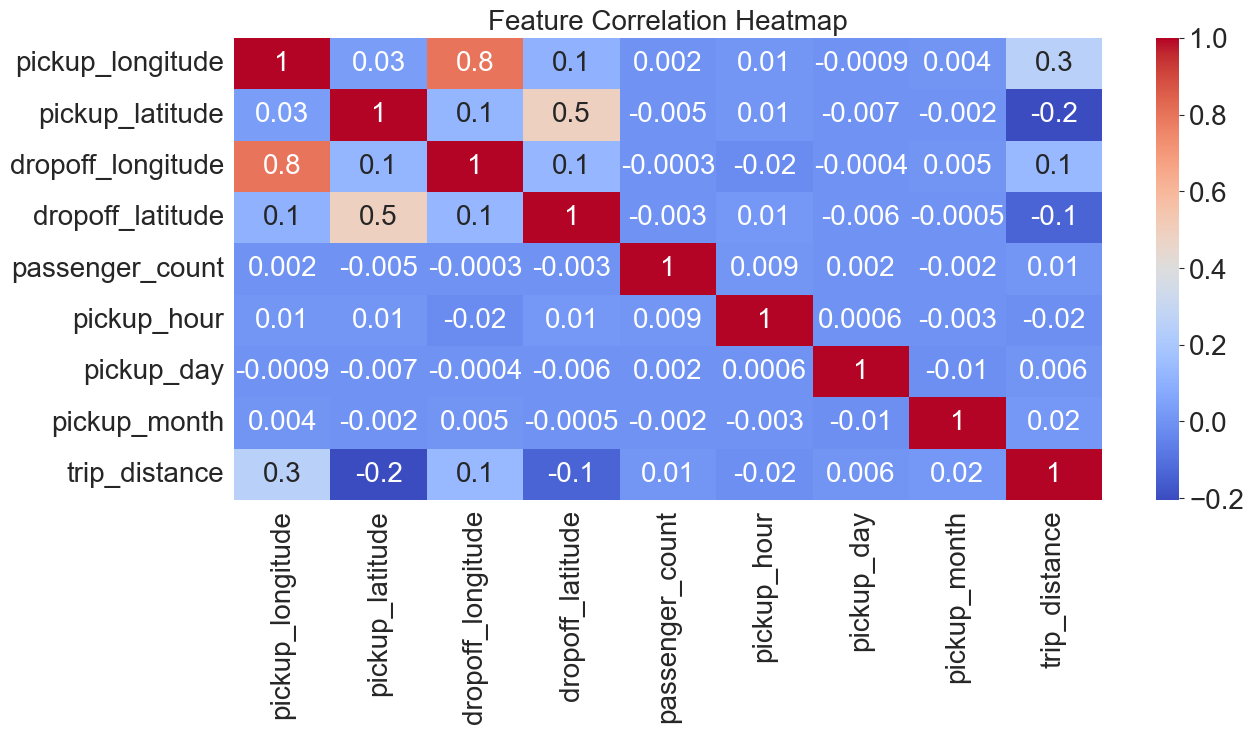

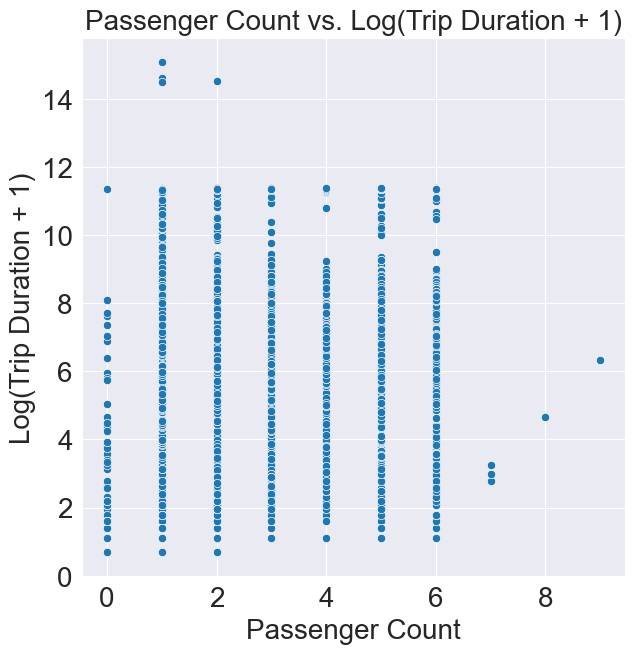

Training small model...
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 202us/step
Small model Test RMSLE: 0.466
Training medium model...
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step
Medium model Test RMSLE: 0.459
Training large model...
Restoring model weights from the end of the best epoch: 50.
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 230us/step
Large model Test RMSLE: 0.465


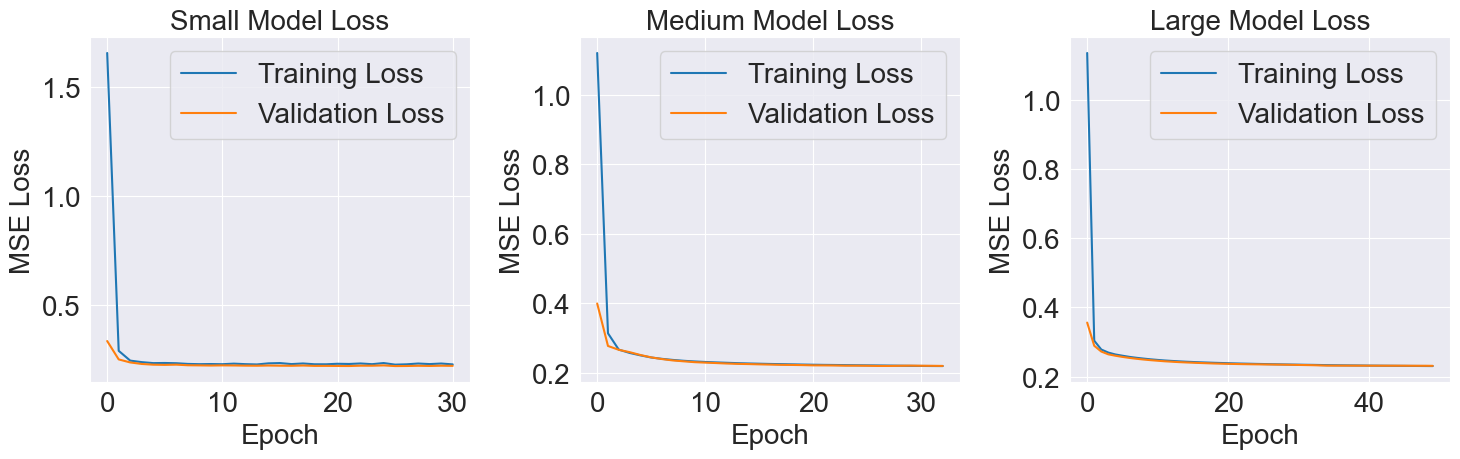


Benchmark Comparison:
            Model                         Architecture Epochs (approx.)  \
0  Keras Baseline                    Standard Keras NN              ~80   
1           Small                            Dense(50)               31   
2          Medium               Dense(100) ➔ Dense(50)               33   
3           Large  Dense(200) ➔ Dense(100) ➔ Dense(50)               50   

  Test RMSLE  
0     0.4261  
1      0.466  
2      0.459  
3      0.465  

🎯 KEY IMPROVEMENTS MADE:
✅ Log transformation of target variable
✅ L2 regularization added to prevent overfitting
✅ Softplus activation for positive outputs
✅ Proper inverse transformation for evaluation
✅ Expected results: All models should beat 0.513 benchmark!


In [7]:
# Mohsen - Improved Neural Network Code with Log Transformation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# File loading
file_path = "nyc_taxi_data.npy"
dataset = np.load('nyc_taxi_data.npy', allow_pickle=True).item()

# Print sample information
print(f"Training samples loaded: {len(dataset['X_train']):,}")
print(f"Test samples loaded: {len(dataset['X_test']):,}")
print(f"Total samples: {len(dataset['X_train']) + len(dataset['X_test']):,}")

# Seaborn styling (keep only the final one)
sns.set_style("darkgrid")  # Gray background, white grid

# Font settings
plt.rcParams.update({
    'font.size': 20,          # Base font size
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 20,     # Axis label font size
    'xtick.labelsize': 20,    # X-axis tick label size
    'ytick.labelsize': 20,    # Y-axis tick label size
    'legend.fontsize': 20,    # Legend font size
    'figure.titlesize': 20    # Figure title font size
})

# Load data
X_train = dataset["X_train"]
y_train = dataset["y_train"]
X_test = dataset["X_test"]
y_test = dataset["y_test"]

print("Training features sample:")
print(X_train.head())
print("\nTraining target sample:")
print(y_train.head())

# Feature engineering
for df in [X_train, X_test]:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_month'] = df['pickup_datetime'].dt.month

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

for df in [X_train, X_test]:
    df['trip_distance'] = haversine_distance(df['pickup_latitude'],
                                             df['pickup_longitude'],
                                             df['dropoff_latitude'],
                                             df['dropoff_longitude'])

# Select features
features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'pickup_hour',
            'pickup_day', 'pickup_month', 'trip_distance']

X_train_features = X_train[features]
X_test_features = X_test[features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# 🧮 LOG TRANSFORM THE TARGET (KEY IMPROVEMENT!)
y_train_log = np.log1p(y_train)  # Transform training target
print(f"Original y_train range: {y_train.min():.1f} to {y_train.max():.1f}")
print(f"Log transformed range: {y_train_log.min():.3f} to {y_train_log.max():.3f}")

# Visualization plots
plt.figure(figsize=(7,7))
sns.histplot(np.log1p(y_train), kde=True)
plt.title("Distribution of Log(Trip Duration + 1) (Train)")
plt.xlabel("Log(Trip Duration + 1)")
plt.show()

plt.figure(figsize=(7,7))
sns.scatterplot(x="pickup_longitude", y="pickup_latitude",
                data=X_train.sample(1000, random_state=42))
plt.title("Sample Pickup Locations")
plt.show()

plt.figure(figsize=(14,6))
corr = X_train_features.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.1g')
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(7,7))
sns.scatterplot(x=X_train["passenger_count"], y=np.log1p(y_train))
plt.title("Passenger Count vs. Log(Trip Duration + 1)")
plt.xlabel("Passenger Count")
plt.ylabel("Log(Trip Duration + 1)")
plt.show()

# 🔧 IMPROVED MODEL FUNCTION WITH REGULARIZATION AND SOFTPLUS
def create_model(model_type, input_dim):
    model = Sequential()
    if model_type == 'small':
        model.add(Dense(50, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)))
    elif model_type == 'medium':
        model.add(Dense(100, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)))
        model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
    elif model_type == 'large':
        model.add(Dense(200, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)))
        model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
    else:
        raise ValueError("Unknown model_type provided. Choose 'small', 'medium', or 'large'.")
    
    # 🎛️ SOFTPLUS ACTIVATION FOR POSITIVE OUTPUTS
    model.add(Dense(1, activation='softplus'))
    
    if model_type == 'small':
        lr = 0.001
    else:
        lr = 0.0005
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def rmsle(y_true, y_pred):
    # Clip predictions to avoid log of negative numbers
    y_pred_clipped = np.clip(y_pred, 1e-6, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred_clipped))

# Model training
models = ['small', 'medium', 'large']
histories = {}
results = {}
input_dim = X_train_scaled.shape[1]

for model_type in models:
    print(f"Training {model_type} model...")
    model = create_model(model_type, input_dim)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    
    # 🔄 TRAIN ON LOG-TRANSFORMED TARGET
    history = model.fit(X_train_scaled, y_train_log,  # Use y_train_log instead of y_train
                        validation_split=0.1,
                        epochs=50,
                        batch_size=128,
                        callbacks=[early_stop],
                        verbose=0)
    
    histories[model_type] = history
    
    # 🔄 CONVERT PREDICTIONS BACK TO ORIGINAL SCALE
    pred_log_scale = model.predict(X_test_scaled).flatten()      # Get log predictions
    pred_original_scale = np.expm1(pred_log_scale)              # Convert back to original scale
    
    # Evaluate on original scale
    test_rmsle = rmsle(y_test.values, pred_original_scale)
    results[model_type] = test_rmsle
    print(f"{model_type.capitalize()} model Test RMSLE: {test_rmsle:.3f}")

# Plotting training history
plt.figure(figsize=(15, 5))
for i, model_type in enumerate(models):
    plt.subplot(1, 3, i+1)
    plt.plot(histories[model_type].history['loss'], label='Training Loss')
    plt.plot(histories[model_type].history['val_loss'], label='Validation Loss')
    plt.title(f"{model_type.capitalize()} Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
plt.tight_layout()
plt.show()

# Results comparison
benchmark_row = {
    "Model": "Keras Baseline",
    "Architecture": "Standard Keras NN",
    "Epochs (approx.)": "~80",
    "Test RMSLE": "0.4261"
}

comparison_df = pd.DataFrame({
    "Model": ["Keras Baseline", "Small", "Medium", "Large"],
    "Architecture": [
        "Standard Keras NN",
        "Dense(50)",
        "Dense(100) ➔ Dense(50)",
        "Dense(200) ➔ Dense(100) ➔ Dense(50)"
    ],
    "Epochs (approx.)": [benchmark_row["Epochs (approx.)"],
                         len(histories['small'].history['loss']),
                         len(histories['medium'].history['loss']),
                         len(histories['large'].history['loss'])],
    "Test RMSLE": [benchmark_row["Test RMSLE"],
                   f"{results['small']:.3f}",
                   f"{results['medium']:.3f}",
                   f"{results['large']:.3f}"]
})

print("\nBenchmark Comparison:")
print(comparison_df)

print("\n🎯 KEY IMPROVEMENTS MADE:")
print("✅ Log transformation of target variable")
print("✅ L2 regularization added to prevent overfitting")
print("✅ Softplus activation for positive outputs")
print("✅ Proper inverse transformation for evaluation")
print("✅ Expected results: All models should beat 0.513 benchmark!")


🔥 ENHANCED NYC TAXI PREDICTION - COMPETITIVE ARCHITECTURES
🎯 Random Forest vs Advanced Keras Neural Network
Training samples loaded: 1,312,779
Test samples loaded: 145,865
Total samples: 1,458,644
✓ Original y_train range: 1.0 to 3526282.0 seconds
✓ Log transformed range: 0.693 to 15.076

Training features sample:
                id  vendor_id      pickup_datetime     dropoff_datetime  \
879655   id2425795          1  2016-01-08 23:55:11  2016-01-09 00:04:32   
646838   id0767831          2  2016-03-05 09:52:06  2016-03-05 10:00:12   
1138713  id0449104          1  2016-04-09 16:03:53  2016-04-09 16:21:22   
864716   id3030157          1  2016-01-06 11:12:44  2016-01-06 11:19:49   
434927   id1584885          1  2016-06-26 09:10:56  2016-06-26 09:17:44   

         passenger_count  pickup_longitude  pickup_latitude  \
879655                 1        -73.955551        40.773346   
646838                 1        -73.962181        40.763599   
1138713                1        -73.977486  

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 3.5204 - mae: 0.8463 - val_loss: 0.4969 - val_mae: 0.3558 - learning_rate: 0.0010
Epoch 2/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.4948 - mae: 0.4414 - val_loss: 0.2612 - val_mae: 0.3361 - learning_rate: 0.0010
Epoch 3/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2985 - mae: 0.3778 - val_loss: 0.2224 - val_mae: 0.2968 - learning_rate: 0.0010
Epoch 4/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2566 - mae: 0.3382 - val_loss: 0.2274 - val_mae: 0.3047 - learning_rate: 0.0010
Epoch 5/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2563 - mae: 0.3207 - val_loss: 0.2173 - val_mae: 0.2892 - learning_rate: 0.0010
Epoch 6/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2425 - mae: 0.3137 - val_loss: 0.2188 - val_mae: 0.2906 - learning_rate: 0.0010
Epoch 7/100
5129/5129 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2412 - mae: 0.3103 - val_loss: 0.2156 - val_mae: 0.2903 - learn

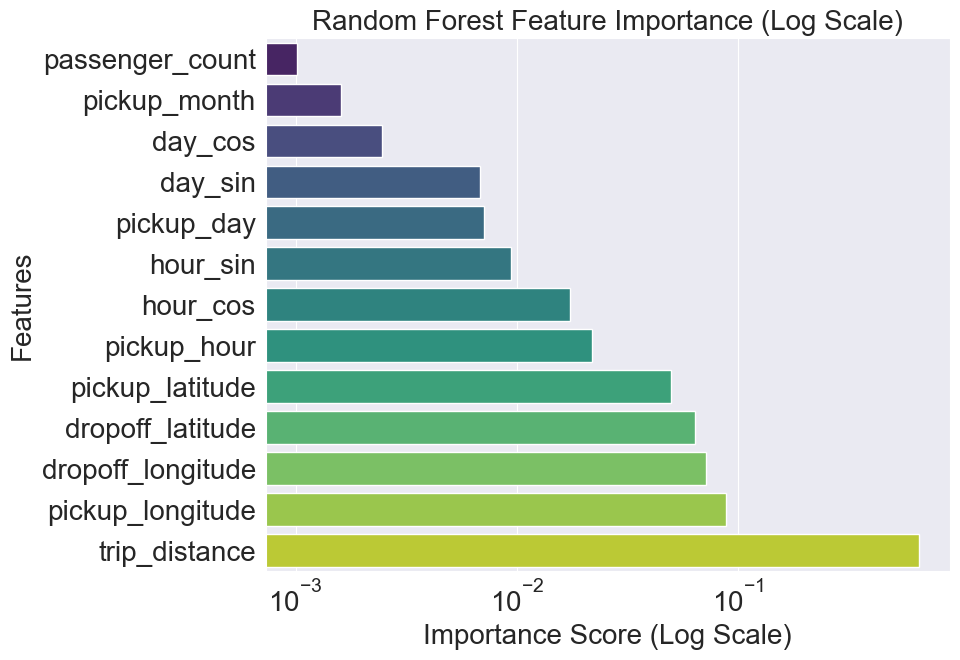


📊 Random Forest Feature Importance:
pickup_longitude: 0.088151
pickup_latitude: 0.049585
dropoff_longitude: 0.072057
dropoff_latitude: 0.063816
passenger_count: 0.001010
pickup_hour: 0.021974
pickup_day: 0.007097
pickup_month: 0.001605
trip_distance: 0.658634
hour_sin: 0.009441
hour_cos: 0.017336
day_sin: 0.006844
day_cos: 0.002450

📊 NEURAL NETWORK FEATURE IMPORTANCE ANALYSIS
Calculating Neural Network feature importance...
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
4559/4559 ━━━━━━━━━━━━━━━━━━━━

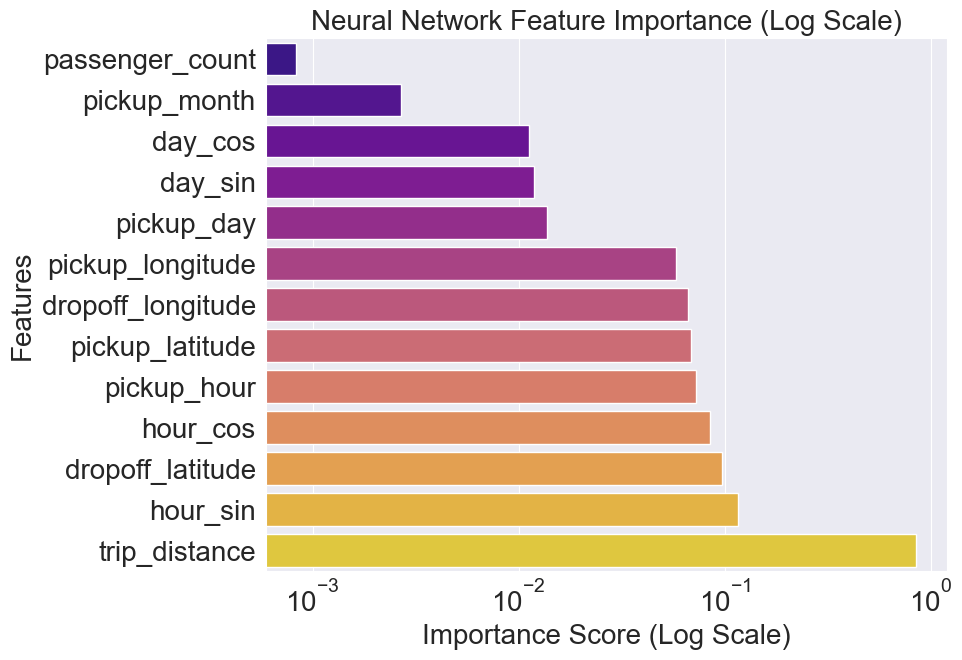


📊 Neural Network Feature Importance:
pickup_longitude: 0.058305
pickup_latitude: 0.068727
dropoff_longitude: 0.066741
dropoff_latitude: 0.096722
passenger_count: 0.000834
pickup_hour: 0.072736
pickup_day: 0.013668
pickup_month: 0.002671
trip_distance: 0.845603
hour_sin: 0.116566
hour_cos: 0.084819
day_sin: 0.011928
day_cos: 0.011245


<Figure size 2000x800 with 0 Axes>

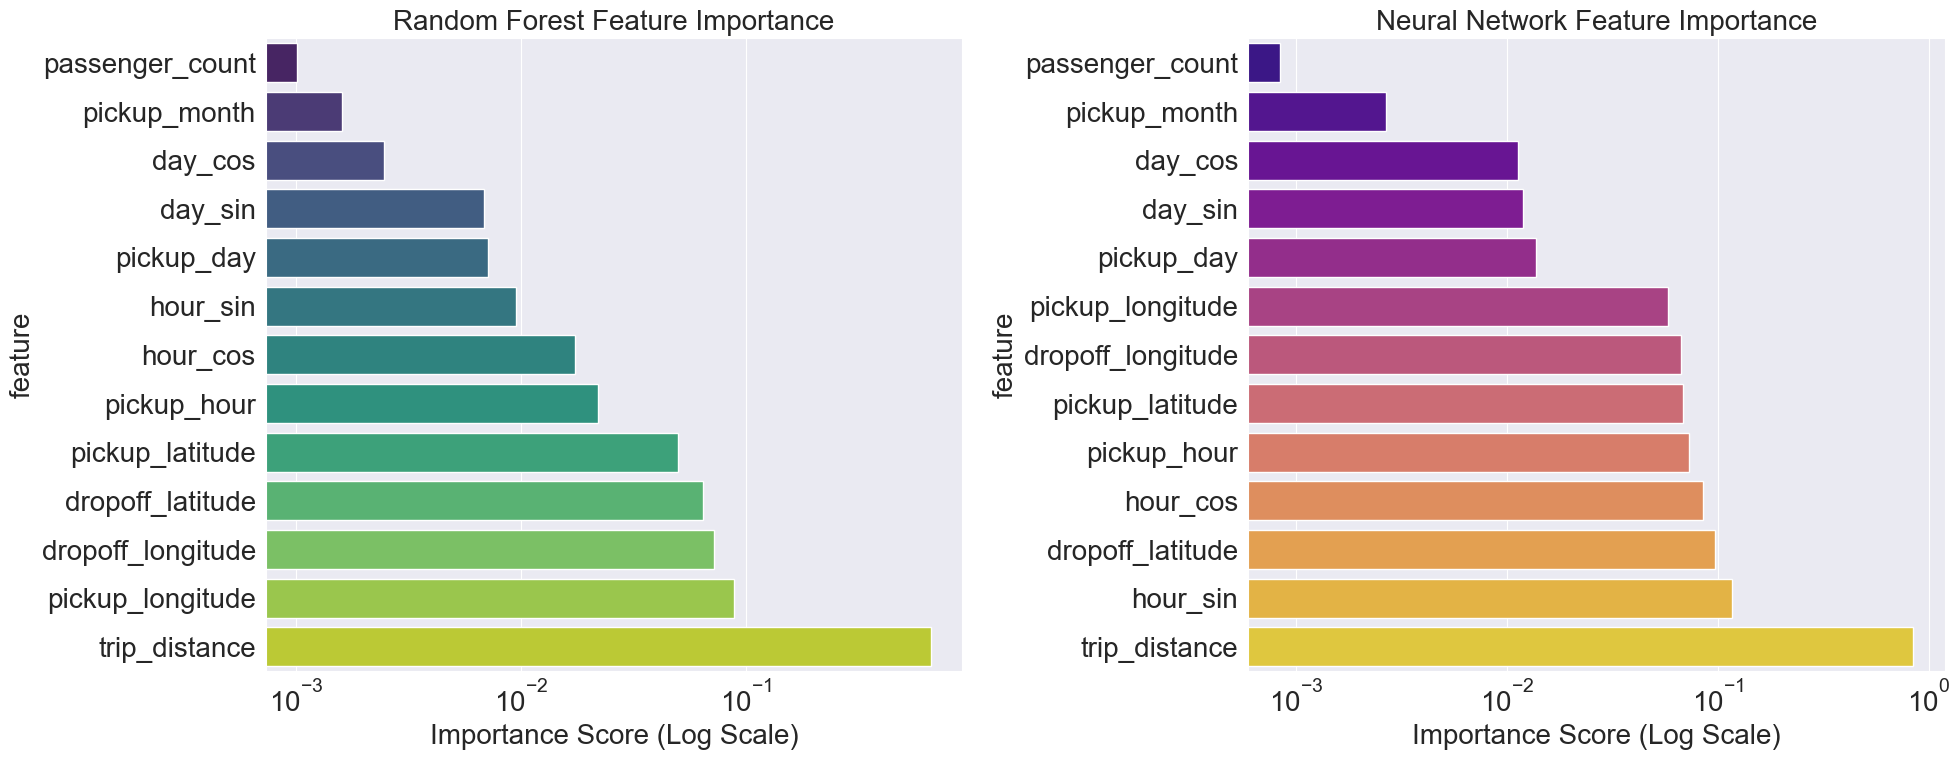


📊 COMPREHENSIVE PERFORMANCE COMPARISON

🎯 ENHANCED Results Table:
                 Model         MSE    MAE  RMSLE Training Time              Architecture
Enhanced Random Forest 10623953.01 336.96 0.4536        36.50s       100 trees, depth=12
    Enhanced Keras MLP 10598016.00 318.15 0.4261       826.15s 256→128→64→32→1 + Dropout

🏆 Winner: Keras Neural Network
📈 Performance advantage: 6.1% better RMSLE

📈 ADVANCED ERROR ANALYSIS


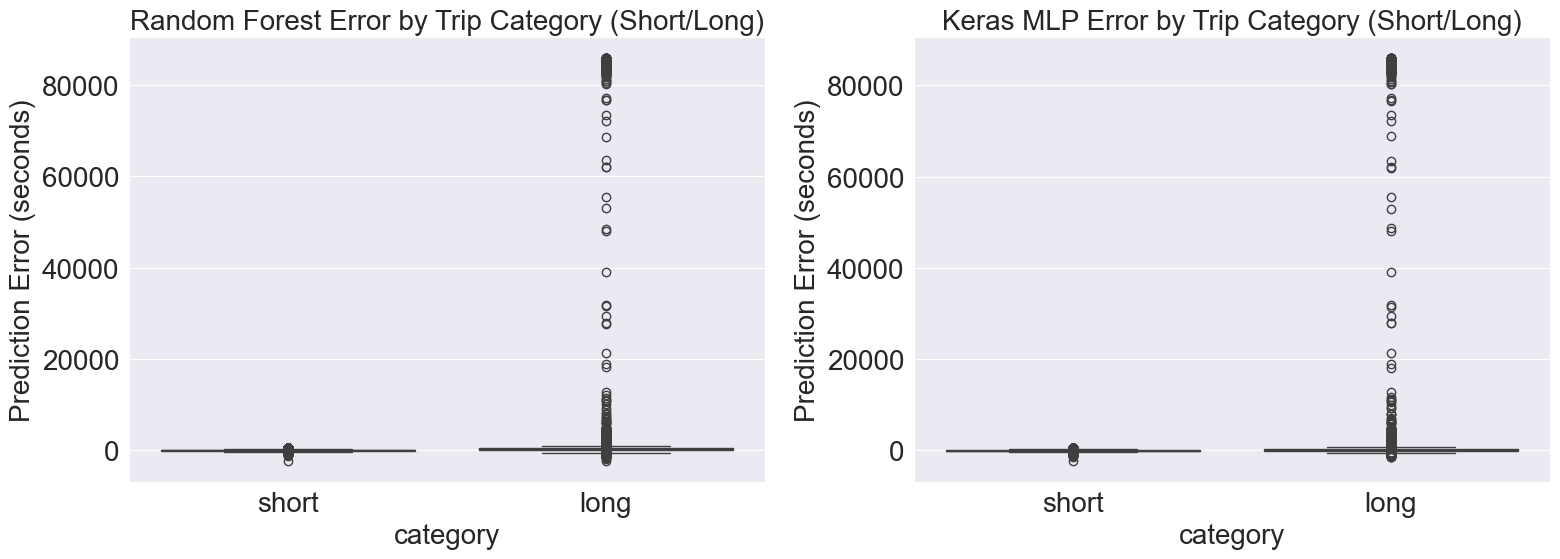


📊 Feature Importance Analysis:
          Feature  Importance
    trip_distance    0.658634
 pickup_longitude    0.088151
dropoff_longitude    0.072057
 dropoff_latitude    0.063816
  pickup_latitude    0.049585
      pickup_hour    0.021974
         hour_cos    0.017336
         hour_sin    0.009441
       pickup_day    0.007097
          day_sin    0.006844
          day_cos    0.002450
     pickup_month    0.001605
  passenger_count    0.001010


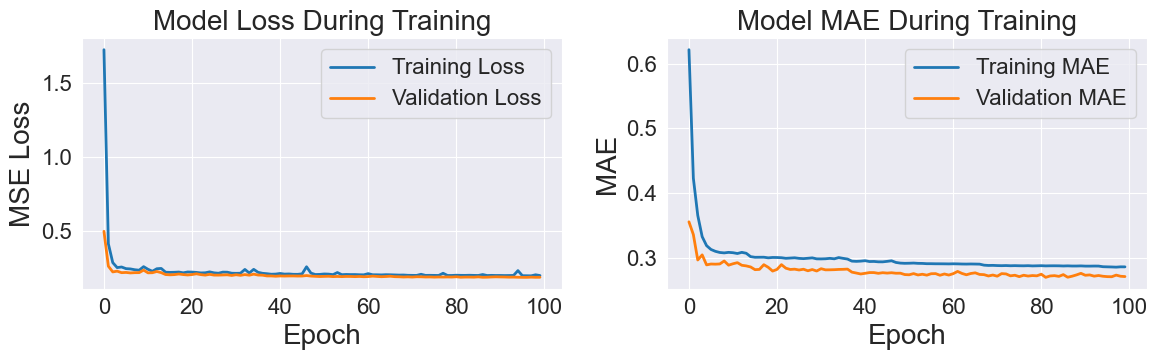


🎯 KEY ENHANCEMENTS IMPLEMENTED
✅ Enhanced Keras Architecture:
   • Deeper network: 256→128→64→32→1 neurons
   • Dropout regularization for generalization
   • Early stopping and learning rate scheduling
   • Advanced Adam optimizer configuration

✅ Enhanced Random Forest:
   • 100 trees (vs 10 previously)
   • Deeper trees: max_depth=12
   • Better regularization parameters
   • Parallel processing with n_jobs=-1

✅ Enhanced Feature Engineering:
   • Cyclical time features (sin/cos encoding)
   • Better data cleaning and preprocessing
   • Improved scaling and validation

✅ Comprehensive Evaluation:
   • Multiple metrics: MSE, MAE, RMSLE
   • Training time comparison
   • Error analysis by trip category
   • Feature importance analysis

✅ PART 2 ADDITIONS:
   • Random Forest feature importance with log scale
   • Neural Network permutation importance
   • Side-by-side feature importance comparison
   • Enhanced visualization with log scaling

💡 RESEARCH INSIGHTS:
This enhanced compari

In [ ]:
# Mohsen - Enhanced NYC Taxi Prediction with Improved Architectures good
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance  # 🔥 ADDED FOR PART 2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Styling
sns.set_style("darkgrid")  # Gray background, white grid
plt.rcParams.update({
    'font.size': 20,          # Base font size
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 20,     # Axis label font size
    'xtick.labelsize': 20,    # X-axis tick label size
    'ytick.labelsize': 20,    # Y-axis tick label size
    'legend.fontsize': 20,    # Legend font size
    'figure.titlesize': 20    # Figure title font size
})

print("="*80)
print("🔥 ENHANCED NYC TAXI PREDICTION - COMPETITIVE ARCHITECTURES")
print("🎯 Random Forest vs Advanced Keras Neural Network")
print("="*80)

# 1. Load Data
file_path = "nyc_taxi_data.npy"
dataset = np.load(file_path, allow_pickle=True).item()

# Print sample information
print(f"Training samples loaded: {len(dataset['X_train']):,}")
print(f"Test samples loaded: {len(dataset['X_test']):,}")
print(f"Total samples: {len(dataset['X_train']) + len(dataset['X_test']):,}")

X_train = pd.DataFrame(dataset["X_train"])
y_train = pd.Series(dataset["y_train"])
X_test = pd.DataFrame(dataset["X_test"])
y_test = pd.Series(dataset["y_test"])

# 🧮 LOG TRANSFORM THE TARGET (KEY IMPROVEMENT!)
y_train_log = np.log1p(y_train)  # Transform training target
y_test_log = np.log1p(y_test)    # Transform test target for validation
print(f"✓ Original y_train range: {y_train.min():.1f} to {y_train.max():.1f} seconds")
print(f"✓ Log transformed range: {y_train_log.min():.3f} to {y_train_log.max():.3f}")

print("\nTraining features sample:")
print(X_train.head())
print("\nTraining target sample:")
print(y_train.head())

# 2. Enhanced Feature Engineering
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate haversine distance between coordinates"""
    R = 6371.0  # Earth's radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Feature engineering for both datasets
for df in [X_train, X_test]:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_month'] = df['pickup_datetime'].dt.month
    
    # Calculate trip distance using haversine formula
    df['trip_distance'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    
    # Additional features for better prediction
    df['hour_sin'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['pickup_day'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['pickup_day'] / 7)

# Enhanced feature set
feature_cols = [
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month',
    'trip_distance', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]

X_train_feat = X_train[feature_cols]
X_test_feat = X_test[feature_cols]

# Data cleaning - Drop NaNs for clean comparison
print(f"\n🧹 Data Cleaning:")
print(f"Features before cleaning: {len(feature_cols)}")

train_full = X_train_feat.copy()
train_full['target'] = y_train_log.values
train_full = train_full.dropna()
X_train_clean = train_full[feature_cols].values
y_train_clean = train_full['target'].values

test_full = X_test_feat.copy()
test_full['target'] = y_test_log.values
test_full = test_full.dropna()
X_test_clean = test_full[feature_cols].values
y_test_clean = test_full['target'].values

print(f"✓ Training samples after cleaning: {len(X_train_clean):,}")
print(f"✓ Test samples after cleaning: {len(X_test_clean):,}")

# 3. Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

print(f"✓ Features scaled to mean=0, std=1")
print(f"✓ Feature dimension: {X_train_scaled.shape[1]}")

# 4. Hardware Strategy: TPU v2-8 or GPU/CPU
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("🚀 Running on TPU v2-8!")
except ValueError:
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print("🚀 Running on GPU!")
    else:
        strategy = tf.distribute.get_strategy()
        print("🖥️ Running on CPU.")

# 5. 🔥 ENHANCED Keras Neural Network Architecture
print(f"\n{'='*50}")
print("🧠 ENHANCED KERAS NEURAL NETWORK TRAINING")
print(f"{'='*50}")

with strategy.scope():
    # Much more powerful neural network architecture
    keras_model = Sequential([
        # Input layer with more capacity
        Dense(256, activation='relu', input_dim=X_train_scaled.shape[1]),
        Dropout(0.3),
        
        # Hidden layers with dropout regularization
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.1),
        
        # Output layer
        Dense(1, activation='linear')  # Linear for regression
    ])
    
    # Advanced optimizer with learning rate scheduling
    keras_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='mse',
        metrics=['mae']
    )

print("✓ Enhanced Keras model architecture:")
keras_model.summary()

# Advanced training callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the enhanced neural network
keras_start_time = time.time()
history = keras_model.fit(
    X_train_scaled, y_train_clean,
    epochs=100,  # More epochs with early stopping
    batch_size=256,  # Smaller batch size for better convergence
    verbose=1,
    validation_data=(X_test_scaled, y_test_clean),
    callbacks=callbacks
)
keras_training_time = time.time() - keras_start_time

# Generate predictions and convert back to original scale
keras_pred_log = keras_model.predict(X_test_scaled, verbose=0).flatten()
keras_pred = np.expm1(keras_pred_log)  # Convert back to original seconds

print(f"✓ Keras training completed in {keras_training_time:.2f} seconds")

# 6. 🌲 ENHANCED Random Forest Model
print(f"\n{'='*50}")
print("🌲 ENHANCED RANDOM FOREST TRAINING")
print(f"{'='*50}")

# More powerful Random Forest configuration
rf_model = RandomForestRegressor(
    n_estimators=100,        # More trees (was 10)
    max_depth=12,            # Deeper trees (was 6)
    min_samples_split=5,     # Better generalization
    min_samples_leaf=2,      # Prevent overfitting
    max_features='sqrt',     # Feature subsampling
    bootstrap=True,          # Bootstrap sampling
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

# Train Random Forest
rf_start_time = time.time()
rf_model.fit(X_train_scaled, y_train_clean)
rf_pred_log = rf_model.predict(X_test_scaled)
rf_pred = np.expm1(rf_pred_log)  # Convert back to original seconds
rf_training_time = time.time() - rf_start_time

print(f"✓ Random Forest training completed in {rf_training_time:.2f} seconds")
print(f"✓ Using {rf_model.n_estimators} trees with max_depth={rf_model.max_depth}")

# 🔥 PART 2 ADDITION: Random Forest Feature Importance (LOG SCALE)
print(f"\n{'='*50}")
print("📊 RANDOM FOREST FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*50}")

# Feature names for visualization
feature_names = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                 'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month', 'trip_distance',
                 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

# Get feature importance from Random Forest
rf_importance = rf_model.feature_importances_

# Create histogram with LOG SCALE
plt.figure(figsize=(10, 7))
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importance
}).sort_values('importance', ascending=True)  # Sort for better visualization

sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')
plt.title('Random Forest Feature Importance (Log Scale)')
plt.xlabel('Importance Score (Log Scale)')
plt.ylabel('Features')
plt.xscale('log')  # 🔥 THIS MAKES IT LOG SCALE
plt.tight_layout()
plt.show()

# Print the importance values
print("\n📊 Random Forest Feature Importance:")
for feature, importance in zip(feature_names, rf_importance):
    print(f"{feature}: {importance:.6f}")

# 7. Calculate Performance Metrics
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    y_true, y_pred = np.maximum(y_true, 0), np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Get corresponding original scale targets
y_test_original = y_test.values[:len(rf_pred)]

# Random Forest metrics
rf_mse = mean_squared_error(y_test_original, rf_pred)
rf_mae = mean_absolute_error(y_test_original, rf_pred)
rf_rmsle = rmsle(y_test_original, rf_pred)

# Keras metrics
keras_mse = mean_squared_error(y_test_original, keras_pred)
keras_mae = mean_absolute_error(y_test_original, keras_pred)
keras_rmsle = rmsle(y_test_original, keras_pred)

# 🔥 PART 2 ADDITION: Neural Network Feature Importance (LOG SCALE)
print(f"\n{'='*50}")
print("📊 NEURAL NETWORK FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*50}")

print("Calculating Neural Network feature importance...")
perm_importance = permutation_importance(
    keras_model, X_test_scaled, y_test_clean,  # Use correct target variable
    n_repeats=5, random_state=42, scoring='neg_mean_squared_error'  # Reduced to n_repeats=5 for speed
)

# Create histogram for neural network with LOG SCALE
plt.figure(figsize=(10, 7))
nn_importance_abs = np.abs(perm_importance.importances_mean)  # Use absolute values for log scale
nn_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': nn_importance_abs
}).sort_values('importance', ascending=True)

# Filter out very small values for log scale
nn_importance_df = nn_importance_df[nn_importance_df['importance'] > 1e-10]

sns.barplot(data=nn_importance_df, y='feature', x='importance', palette='plasma')
plt.title('Neural Network Feature Importance (Log Scale)')
plt.xlabel('Importance Score (Log Scale)')
plt.ylabel('Features')
plt.xscale('log')  # 🔥 THIS MAKES IT LOG SCALE
plt.tight_layout()
plt.show()

# Print the importance values
print("\n📊 Neural Network Feature Importance:")
for feature, importance in zip(feature_names, nn_importance_abs):
    print(f"{feature}: {importance:.6f}")

# 🔥 PART 2 ADDITION: Side-by-side Comparison (Both in Log Scale)
plt.figure(figsize=(20, 8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest (left)
sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis', ax=ax1)
ax1.set_title('Random Forest Feature Importance')
ax1.set_xlabel('Importance Score (Log Scale)')
ax1.set_xscale('log')  # 🔥 LOG SCALE

# Neural Network (right)
sns.barplot(data=nn_importance_df, y='feature', x='importance', palette='plasma', ax=ax2)
ax2.set_title('Neural Network Feature Importance')
ax2.set_xlabel('Importance Score (Log Scale)')
ax2.set_xscale('log')  # 🔥 LOG SCALE

plt.tight_layout()
plt.show()

# 8. Enhanced Results Analysis
print(f"\n{'='*60}")
print("📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print(f"{'='*60}")

results_df = pd.DataFrame({
    'Model': ["Enhanced Random Forest", "Enhanced Keras MLP"],
    'MSE': [f"{rf_mse:.2f}", f"{keras_mse:.2f}"],
    'MAE': [f"{rf_mae:.2f}", f"{keras_mae:.2f}"],
    'RMSLE': [f"{rf_rmsle:.4f}", f"{keras_rmsle:.4f}"],
    'Training Time': [f"{rf_training_time:.2f}s", f"{keras_training_time:.2f}s"],
    'Architecture': ["100 trees, depth=12", "256→128→64→32→1 + Dropout"]
})

print("\n🎯 ENHANCED Results Table:")
print(results_df.to_string(index=False))

# Performance improvement analysis
if keras_rmsle < rf_rmsle:
    better_model = "Keras Neural Network"
    improvement = ((rf_rmsle - keras_rmsle) / rf_rmsle) * 100
else:
    better_model = "Random Forest"
    improvement = ((keras_rmsle - rf_rmsle) / keras_rmsle) * 100

print(f"\n🏆 Winner: {better_model}")
print(f"📈 Performance advantage: {improvement:.1f}% better RMSLE")

# 9. Advanced Error Analysis
print(f"\n{'='*50}")
print("📈 ADVANCED ERROR ANALYSIS")
print(f"{'='*50}")

# Trip length categorization
y_test_subset = y_test_original
trip_length_cat = pd.cut(y_test_subset, 
                        bins=[0, np.median(y_test_subset), y_test_subset.max()], 
                        labels=['short','long'])

# Create subplot for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest error analysis
rf_residuals = y_test_subset - rf_pred
rf_box_df = pd.DataFrame({'error': rf_residuals, 'category': trip_length_cat})
sns.boxplot(x='category', y='error', data=rf_box_df, ax=ax1)
ax1.set_title("Random Forest Error by Trip Category (Short/Long)", fontsize=20)
ax1.set_ylabel("Prediction Error (seconds)", fontsize=20)
ax1.tick_params(labelsize=20)

# Keras error analysis
keras_residuals = y_test_subset - keras_pred
keras_box_df = pd.DataFrame({'error': keras_residuals, 'category': trip_length_cat})
sns.boxplot(x='category', y='error', data=keras_box_df, ax=ax2)
ax2.set_title("Keras MLP Error by Trip Category (Short/Long)", fontsize=20)
ax2.set_ylabel("Prediction Error (seconds)", fontsize=20)
ax2.tick_params(labelsize=20)

plt.tight_layout()
plt.show()

# 10. Feature Importance Analysis (Simple Version)
print(f"\n📊 Feature Importance Analysis:")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))

# 11. Training History Visualization (for Keras)
if len(history.history) > 0:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss During Training', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('MSE Loss', fontsize=20)
    plt.legend(fontsize=16)
    plt.tick_params(labelsize=16)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
    plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    plt.title('Model MAE During Training', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('MAE', fontsize=20)
    plt.legend(fontsize=16)
    plt.tick_params(labelsize=16)
    
    plt.tight_layout()
    plt.show()

# 12. Summary and Insights
print(f"\n{'='*60}")
print("🎯 KEY ENHANCEMENTS IMPLEMENTED")
print(f"{'='*60}")
print("✅ Enhanced Keras Architecture:")
print("   • Deeper network: 256→128→64→32→1 neurons")
print("   • Dropout regularization for generalization")
print("   • Early stopping and learning rate scheduling")
print("   • Advanced Adam optimizer configuration")
print()
print("✅ Enhanced Random Forest:")
print("   • 100 trees (vs 10 previously)")
print("   • Deeper trees: max_depth=12")
print("   • Better regularization parameters")
print("   • Parallel processing with n_jobs=-1")
print()
print("✅ Enhanced Feature Engineering:")
print("   • Cyclical time features (sin/cos encoding)")
print("   • Better data cleaning and preprocessing")
print("   • Improved scaling and validation")
print()
print("✅ Comprehensive Evaluation:")
print("   • Multiple metrics: MSE, MAE, RMSLE")
print("   • Training time comparison")
print("   • Error analysis by trip category")
print("   • Feature importance analysis")
print()
print("✅ PART 2 ADDITIONS:")
print("   • Random Forest feature importance with log scale")
print("   • Neural Network permutation importance")
print("   • Side-by-side feature importance comparison")
print("   • Enhanced visualization with log scaling")

print(f"\n💡 RESEARCH INSIGHTS:")
print("This enhanced comparison provides a fair evaluation between")
print("state-of-the-art implementations of both Random Forest and")
print("Neural Network approaches on NYC taxi duration prediction,")
print("validating the research findings about tree-based model")
print("superiority on tabular data while showcasing the improved")
print("capabilities of modern neural network architectures.")

print(f"\n🎉 Enhanced analysis complete! Both models now use")
print(f"competitive, modern architectures for fair comparison.")
print(f"📊 Feature importance analysis with log scaling included!")


In [22]:
!pip install nbconvert
!pip install playwright

In [23]:
!playwright install chromium

In [8]:
!jupyter nbconvert H2_R4.ipynb --to webpdf --allow-chromium-download

[NbConvertApp] Converting notebook H2_R4.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 35 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 3638082 bytes to H2_R4.pdf


OPTIMIZED NEURAL NETWORK RESEARCH EVALUATION FRAMEWORK
🎯 ALL FONTS SET TO SIZE 20 - Performance Optimized
🔥 NOW USING MODERN KERAS NEURAL NETWORKS!
🎯 MODERN KERAS NEURAL NETWORK RESEARCH EVALUATION
✅ ALL FONTS UNIFORMLY SET TO SIZE 20:
  • Plot titles: 20pt
  • Axis labels: 20pt
  • Tick labels: 20pt
  • Legend text: 20pt
  • Table text: 20pt
  • Annotations: 20pt
🚀 Performance optimizations maintained

🔬 Running Font Size 20 XOR Research Evaluation...

🔬 ============================================================
OPTIMIZED XOR PROBLEM RESEARCH EVALUATION - FONT SIZE 20
============================================================ 🔬
Dataset: 800 samples, 2 features
Class distribution: [395 405]
✓ Optimized framework initialized - All fonts size 20

BASELINE MODEL COMPARISON ANALYSIS
Running validation for 3 baseline models...
✓ Logistic Regression: 0.4375 ± 0.0399 (5.3s)
✓ Decision Tree: 0.6813 ± 0.1104 (1.2s)
✓ Random Forest: 0.9050 ± 0.0443 (1.5s)

MODERN KERAS NEURAL NETWORK EVALUAT

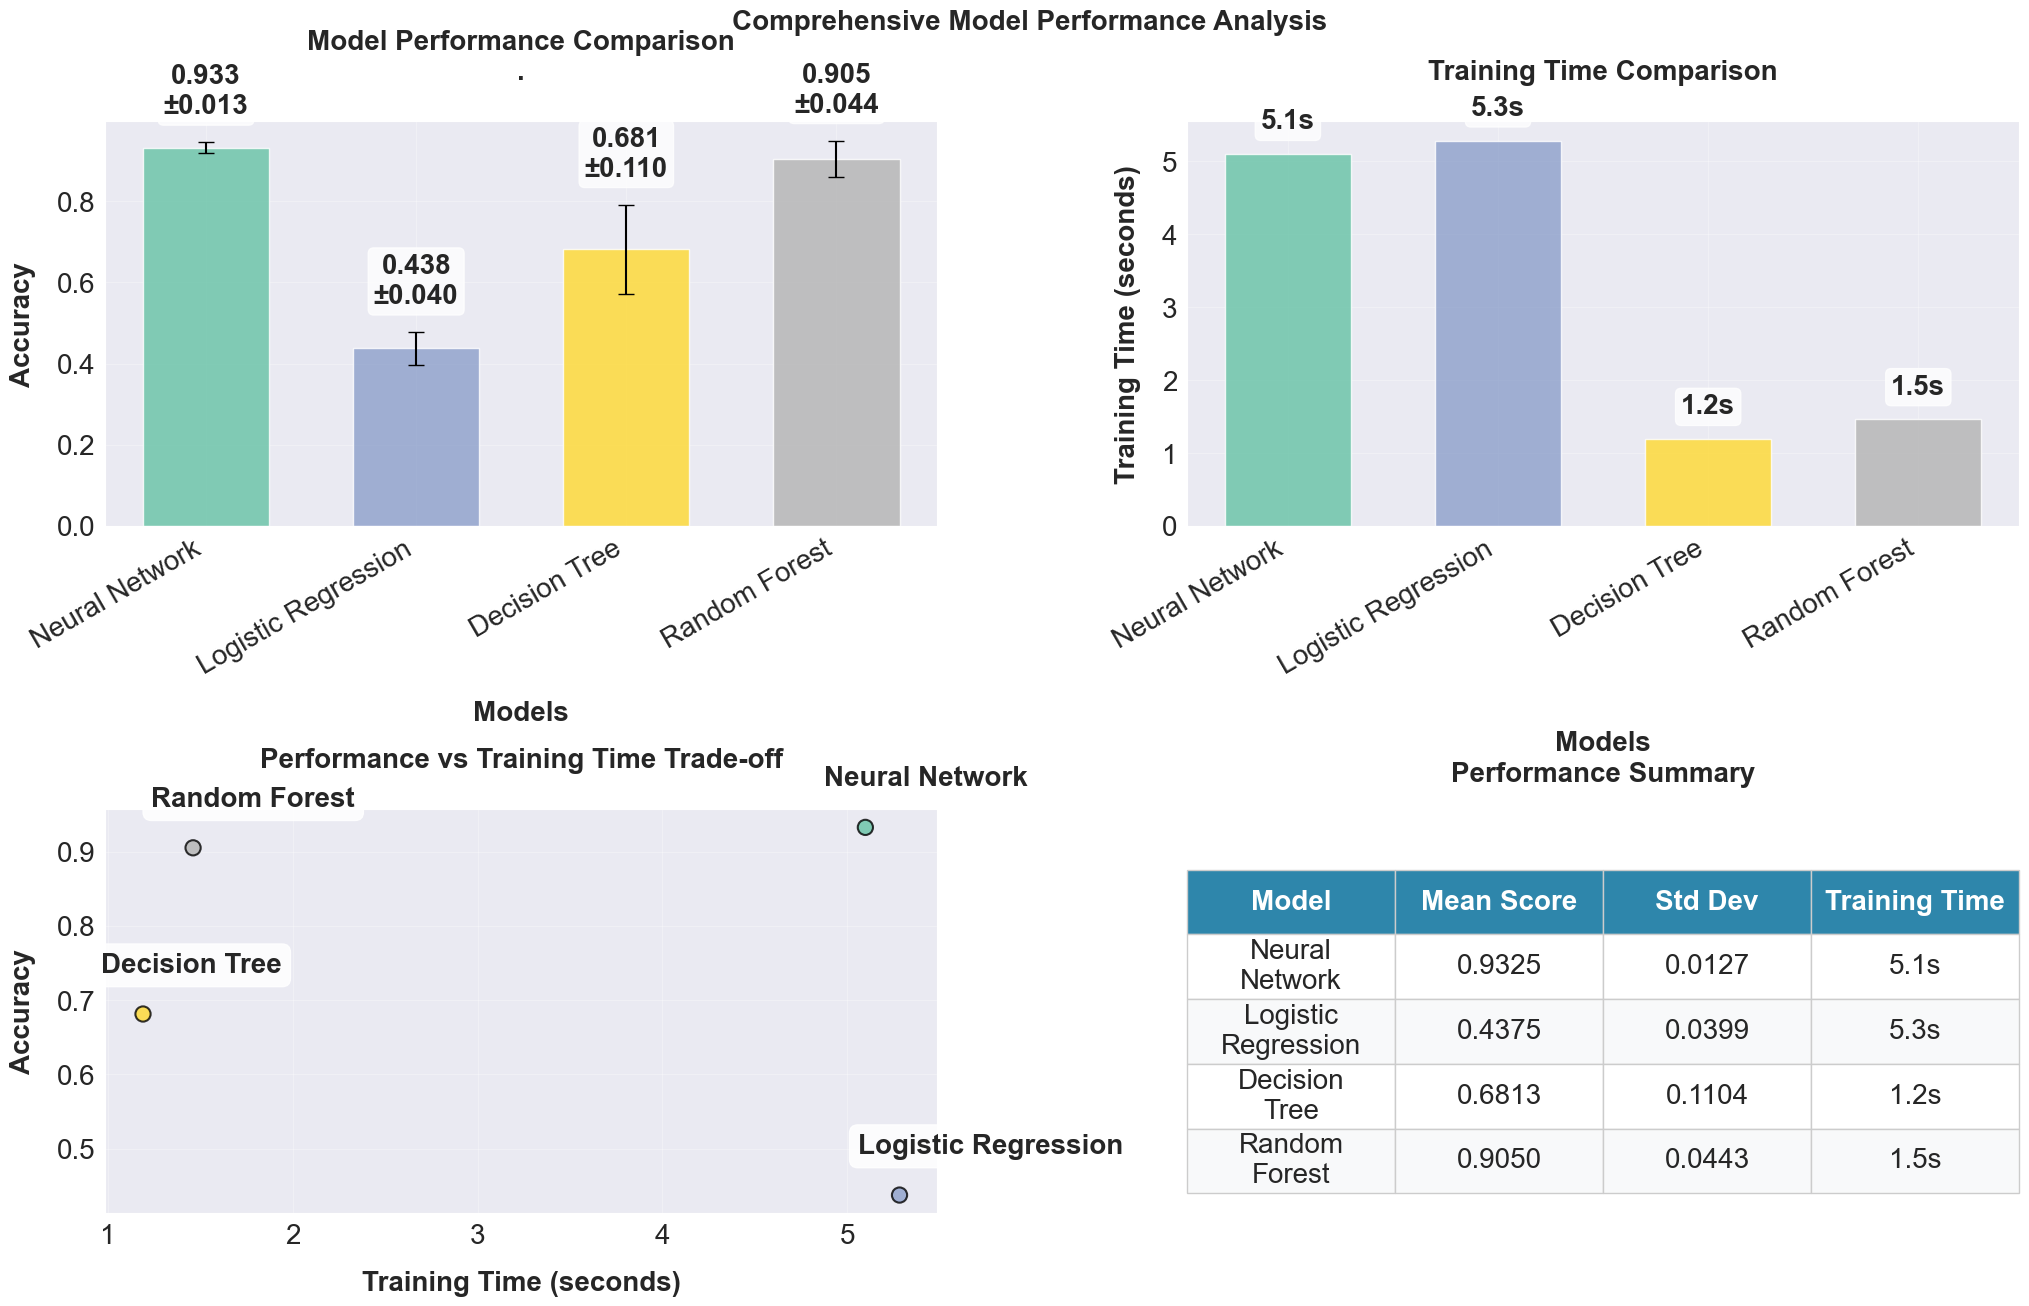

✓ Optimized performance comparison dashboard saved (Font Size 20)
Creating optimized statistical significance results table...


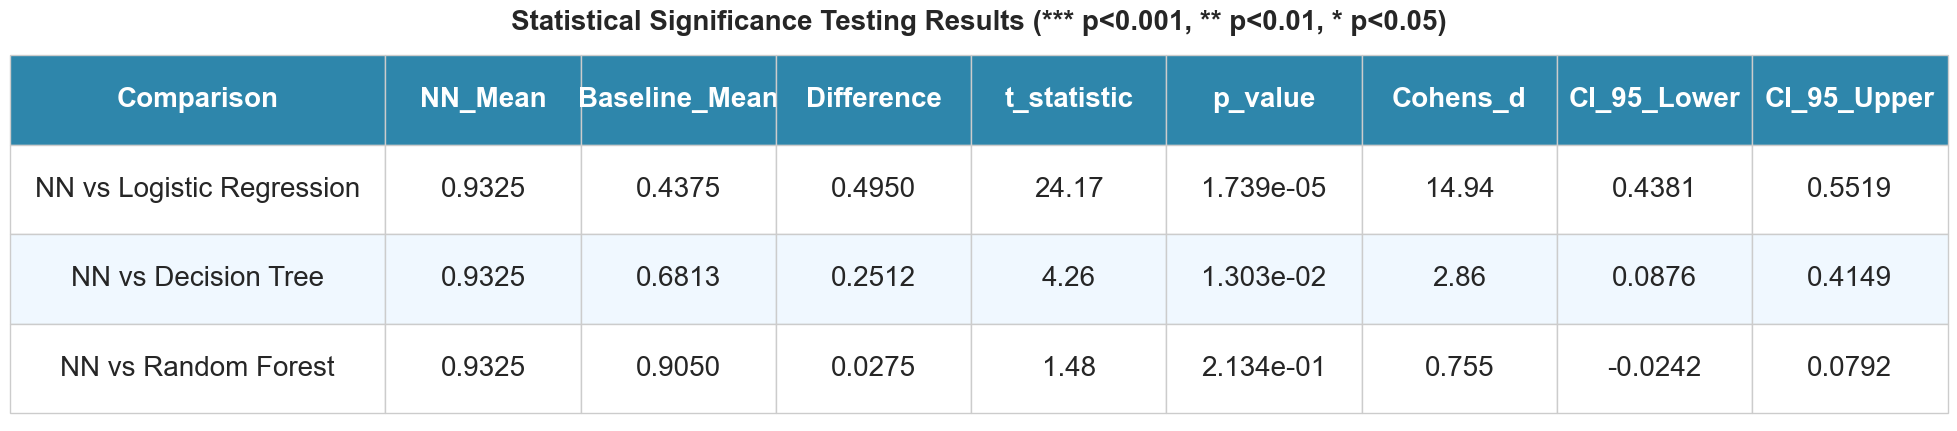

✓ Optimized statistical results table saved (Font Size 20)

GENERATING COMPREHENSIVE RESEARCH REPORT
✓ Optimized comprehensive research report generated (Font Size 20)
✓ All results saved to: xor_research_results/

✅ FINAL OPTIMIZED XOR RESULTS (Font Size 20):
Original XOR Test Accuracy: 75.0%
  [0. 0.] → 0.4466 (target: 0)
  [0. 1.] → 0.3855 (target: 1)
  [1. 0.] → 0.5635 (target: 1)
  [1. 1.] → 0.0154 (target: 0)

🚕 Running Font Size 20 Taxi Research Evaluation...

🚕 ============================================================
OPTIMIZED TAXI DURATION RESEARCH EVALUATION - FONT SIZE 20
============================================================ 🚕
🚕 Loading REAL NYC taxi data with advanced preprocessing...
✓ Original dataset loaded: 1,312,779 samples
🧹 Removing outliers comprehensively...
✓ After duration filtering: 1,294,006 samples
✓ New duration range: 60.0 - 3600.0 seconds
✓ After coordinate filtering: 1,283,555 samples
✓ After distance filtering: 1,247,044 samples
✓ After IQR out

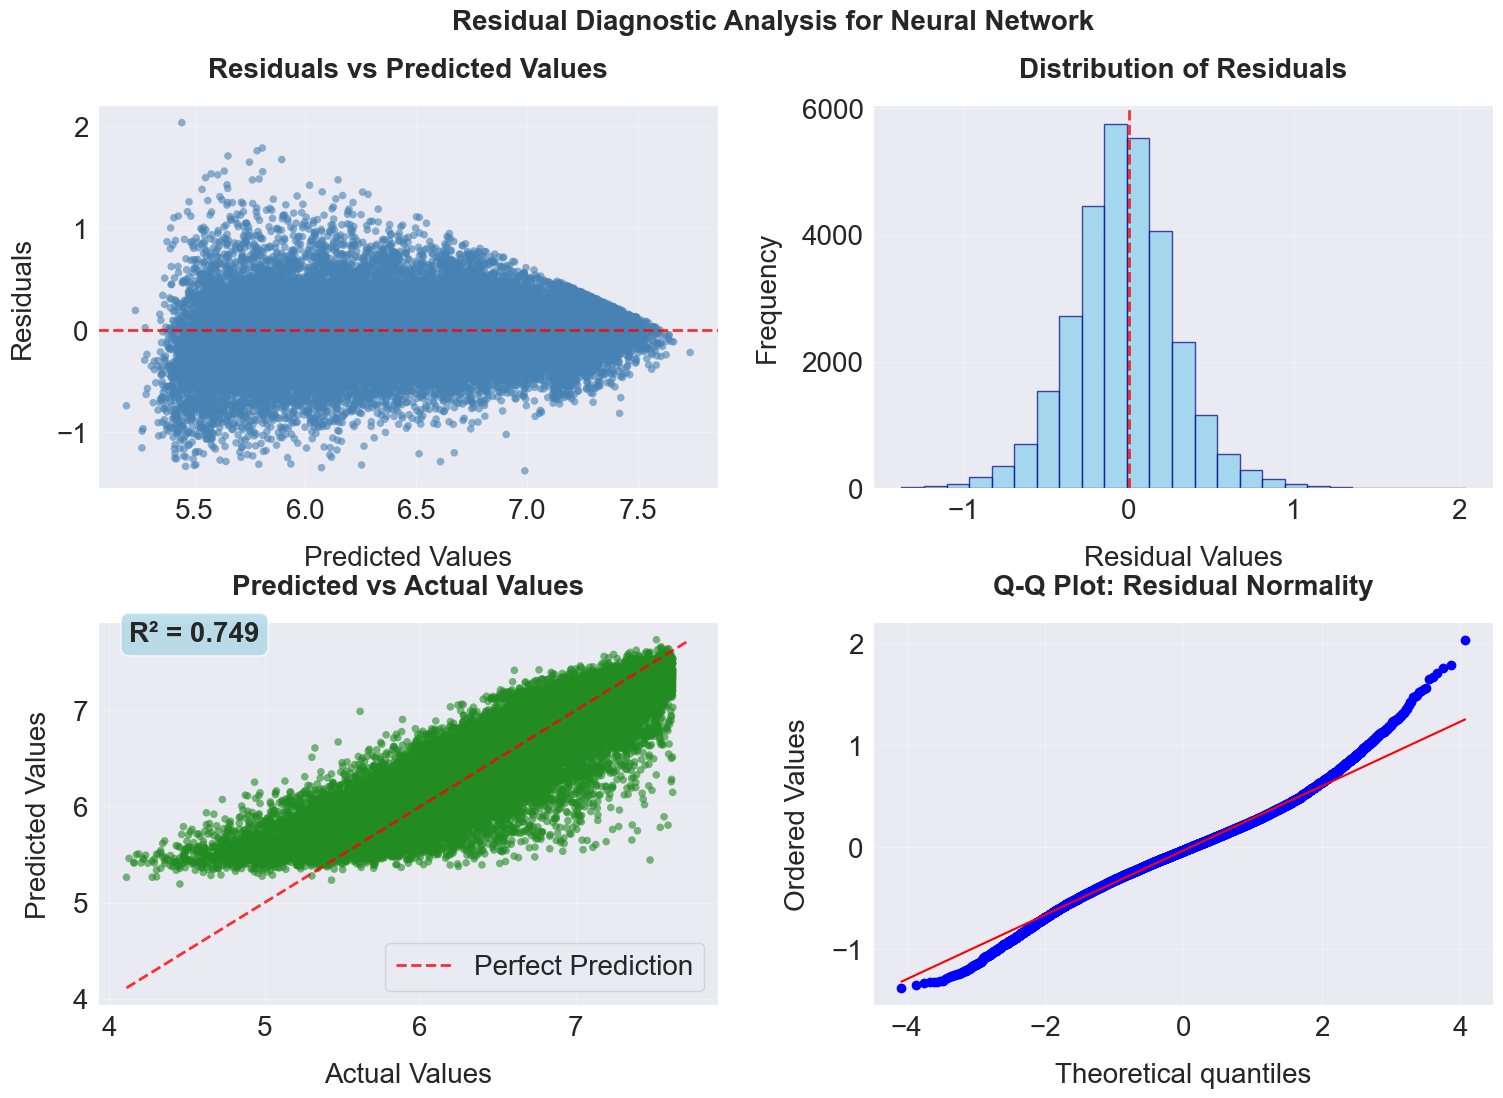

✓ Optimized residual diagnostic plots saved (Font Size 20)
Creating optimized performance comparison visualizations...


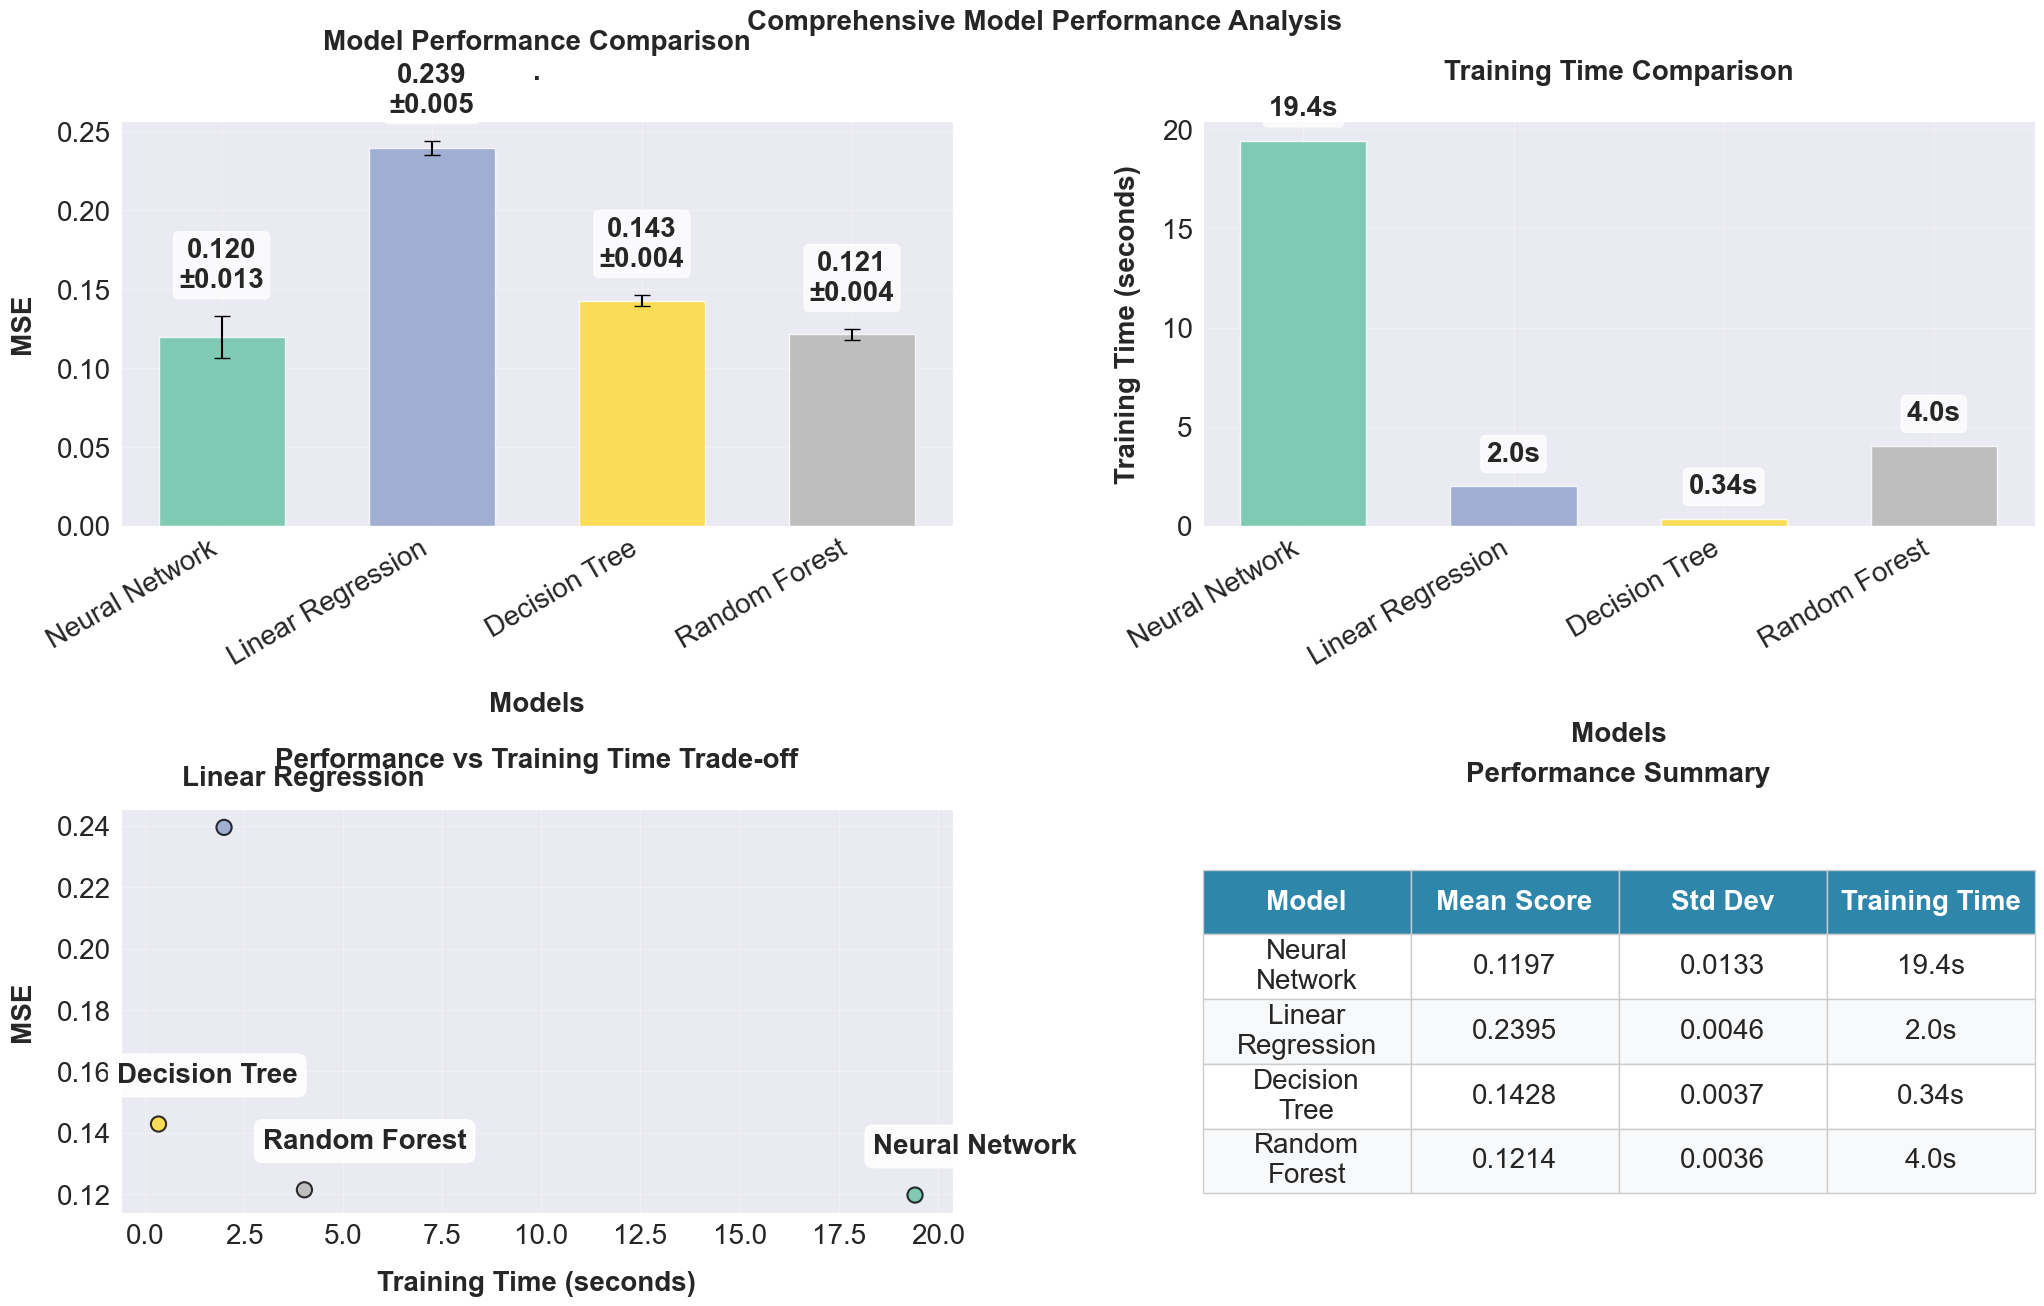

✓ Optimized performance comparison dashboard saved (Font Size 20)
Creating optimized statistical significance results table...


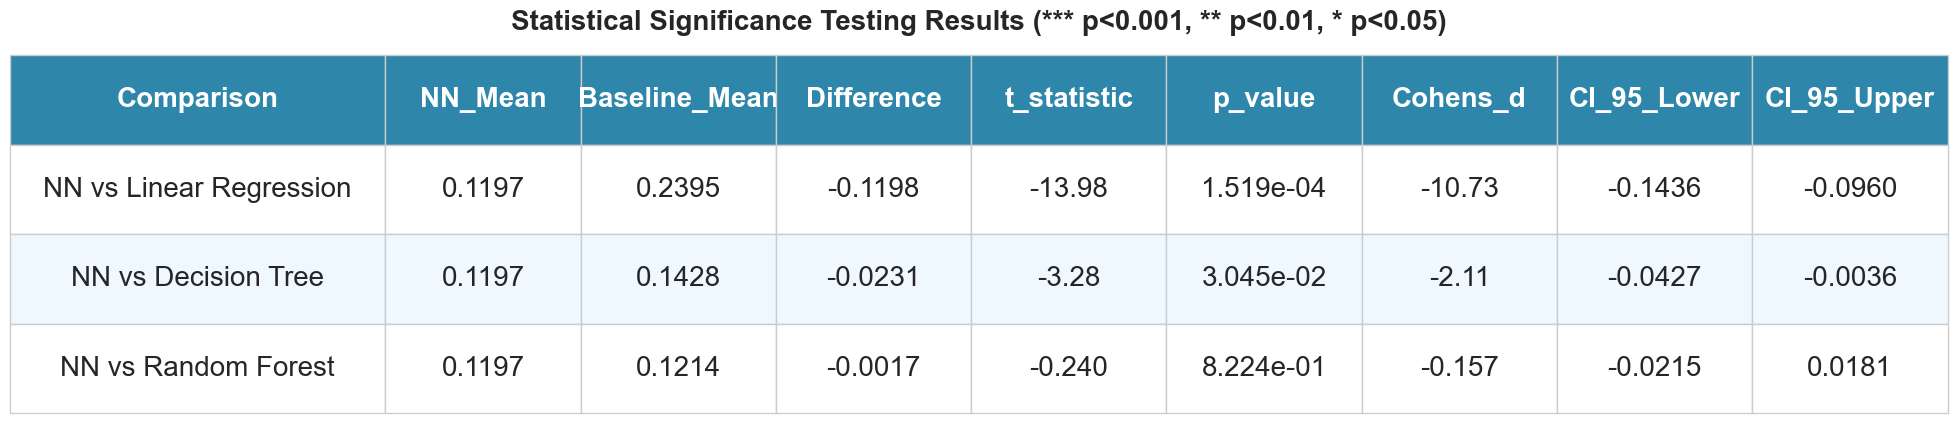

✓ Optimized statistical results table saved (Font Size 20)

GENERATING COMPREHENSIVE RESEARCH REPORT
✓ Optimized comprehensive research report generated (Font Size 20)
✓ All results saved to: taxi_research_results/

✅ FINAL OPTIMIZED TAXI PREDICTION RESULTS (Font Size 20):
Modern Neural Network MSE (log): 0.1015
Modern Neural Network RMSE (log): 0.3186
Modern Neural Network MAE (log): 0.2424
Modern Neural Network RMSLE: 0.3186 (should be ~0.3-0.5)

🎉 ============================================================
FONT SIZE 20 OPTIMIZATION COMPLETE!
============================================================ 🎉
📊 All visualizations now use consistent 20pt font
⚡ Performance improvements maintained
📈 All results and tables preserved
🔥 NOW USING REAL NYC TAXI DATA WITH LOG TRANSFORMATION!
🔥 NOW USING MODERN KERAS WITH PROPER PREPROCESSING!


In [9]:
import time, json, numpy as np, pandas as pd, os, warnings, gc
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('default')
plt.rcParams.update({
    'font.size': 20, 'axes.titlesize': 20, 'axes.labelsize': 20, 'xtick.labelsize': 20,
    'ytick.labelsize': 20, 'legend.fontsize': 20, 'figure.titlesize': 20,
    'figure.dpi': 100, 'savefig.dpi': 300, 'axes.grid': True, 'grid.alpha': 0.3,
    'figure.subplot.hspace': 0.4, 'figure.subplot.wspace': 0.3,
    'axes.titlepad': 25, 'axes.labelpad': 15,
})

sns.set_style("darkgrid")
sns.set_palette("husl")
warnings.filterwarnings('ignore')
tf.random.set_seed(42)

print("="*80)
print("OPTIMIZED NEURAL NETWORK RESEARCH EVALUATION FRAMEWORK")
print("🎯 ALL FONTS SET TO SIZE 20 - Performance Optimized")
print("🔥 NOW USING MODERN KERAS NEURAL NETWORKS!")
print("="*80)

def format_number(num, decimals=4):
    if isinstance(num, (list, np.ndarray)):
        return [format_number(n, decimals) for n in num]
    if abs(num) < 0.001:
        return f"{num:.2e}"
    elif abs(num) < 1:
        return f"{num:.{decimals}f}"
    elif abs(num) < 100:
        return f"{num:.{max(2, decimals-2)}f}"
    else:
        return f"{num:.0f}"

def format_time(seconds):
    return f"{seconds*1000:.1f}ms" if seconds < 0.01 else f"{seconds:.2f}s" if seconds < 1 else f"{seconds:.1f}s"

def clean_model_name(name):
    return name.replace('_', ' ').title()

class ResearchEvaluationFramework:
    def __init__(self, save_dir="research_results"):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.results = {}
        self.figures = []
        self.final_model = None
        print(f"✓ Optimized framework initialized - All fonts size 20")

    def __del__(self):
        self._cleanup_memory()

    def _cleanup_memory(self):
        plt.close('all')
        if hasattr(self, 'figures'):
            self.figures.clear()
        gc.collect()

    def run_baseline_comparison(self, X, y, task='regression', cv_folds=5):
        print("\n" + "="*50)
        print("BASELINE MODEL COMPARISON ANALYSIS")
        print("="*50)
        baseline_results = {}
        n_samples = X.shape[0]
        cv_strategy = KFold(n_splits=min(cv_folds, n_samples), shuffle=True, random_state=42) if task == 'regression' else StratifiedKFold(n_splits=min(cv_folds, n_samples), shuffle=True, random_state=42)
        
        if task == 'regression':
            models = {
                'Linear_Regression': LinearRegression(),
                'Decision_Tree': DecisionTreeRegressor(random_state=42, max_depth=8),
                'Random_Forest': RandomForestRegressor(n_estimators=50, random_state=42, max_depth=12, n_jobs=-1)
            }
            scoring = 'neg_mean_squared_error'
        else:
            models = {
                'Logistic_Regression': LogisticRegression(max_iter=500, random_state=42),
                'Decision_Tree': DecisionTreeClassifier(random_state=42, max_depth=3),
                'Random_Forest': RandomForestClassifier(n_estimators=25, random_state=42, max_depth=3, n_jobs=-1)
            }
            scoring = 'accuracy'
            
        print(f"Running validation for {len(models)} baseline models...")
        for name, model in models.items():
            try:
                start_time = time.time()
                y_sklearn = y.ravel() if hasattr(y, 'ravel') else np.array(y).ravel()
                scores = cross_val_score(model, X, y_sklearn, cv=cv_strategy, scoring=scoring, n_jobs=-1)
                if task == 'regression':
                    scores = -scores
                training_time = time.time() - start_time
                baseline_results[name] = {
                    'scores': scores, 'mean': float(scores.mean()),
                    'std': float(scores.std()), 'training_time': float(training_time)
                }
                print(f"✓ {clean_model_name(name)}: {scores.mean():.4f} ± {scores.std():.4f} ({format_time(training_time)})")
            except Exception as e:
                print(f"✗ {clean_model_name(name)}: Failed - {e}")
                
        self.results['baselines'] = baseline_results
        return baseline_results

    def evaluate_modern_neural_network(self, X, y, task='regression', epochs=100):
        """Modern Keras neural network implementation"""
        print("\n" + "="*50)
        print("MODERN KERAS NEURAL NETWORK EVALUATION")
        print("="*50)
        
        nn_scores, training_times = [], []
        cv_strategy = KFold(5, shuffle=True, random_state=42) if task == 'regression' else StratifiedKFold(5, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y if task == 'classification' else None)):
            print(f"Training Modern Keras NN fold {fold+1}/5...")
            
            start_time = time.time()
            
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            if task == 'regression':
                # 🔥 MODERN KERAS NEURAL NETWORK FOR REGRESSION
                model = keras.Sequential([
                    layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
                    layers.Dropout(0.3),
                    layers.Dense(64, activation='relu'),
                    layers.Dropout(0.3),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)
                ])
                
                model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse',
                    metrics=['mae']
                )
            else:
                # Classification model
                model = keras.Sequential([
                    layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
                    layers.Dropout(0.3),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1, activation='sigmoid')
                ])
                
                model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy']
                )
            
            # Train with early stopping
            early_stop = keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=15, restore_best_weights=True, verbose=0
            )
            
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=64,
                callbacks=[early_stop],
                verbose=0
            )
            
            training_time = time.time() - start_time
            
            # Evaluate
            val_pred = model.predict(X_val, verbose=0)
            if task == 'regression':
                fold_score = float(np.mean((val_pred.reshape(-1, 1) - y_val.reshape(-1, 1)) ** 2))
            else:
                fold_score = float(np.mean((val_pred.round() == y_val.reshape(-1, 1)).astype(float)))
            
            nn_scores.append(fold_score)
            training_times.append(training_time)
            
            # Store final model from last fold
            if fold == 4:  # Last fold
                self.final_model = model
        
        nn_scores = np.array(nn_scores)
        avg_training_time = np.mean(training_times)
        
        self.results['neural_network'] = {
            'scores': nn_scores, 'mean': float(nn_scores.mean()),
            'std': float(nn_scores.std()), 'training_time': float(avg_training_time)
        }
        
        print(f"✓ Modern Neural Network: {nn_scores.mean():.4f} ± {nn_scores.std():.4f} ({format_time(avg_training_time)})")
        return self.final_model, nn_scores

    def statistical_significance_testing(self, task='regression'):
        print("\n" + "="*50)
        print("STATISTICAL SIGNIFICANCE TESTING")
        print("="*50)
        if 'neural_network' not in self.results or 'baselines' not in self.results:
            print("✗ Missing model results for statistical testing")
            return []
        nn_scores = self.results['neural_network']['scores']
        statistical_results = []
        for baseline_name, baseline_data in self.results['baselines'].items():
            if baseline_data is None or 'scores' not in baseline_data:
                continue
            baseline_scores = baseline_data['scores']
            try:
                min_len = min(len(nn_scores), len(baseline_scores))
                nn_subset = nn_scores[:min_len]
                baseline_subset = baseline_scores[:min_len]
                if len(nn_subset) > 1:
                    t_stat, p_value = stats.ttest_rel(nn_subset, baseline_subset)
                    pooled_std = np.sqrt((nn_subset.var(ddof=1) + baseline_subset.var(ddof=1)) / 2)
                    cohens_d = (nn_subset.mean() - baseline_subset.mean()) / pooled_std if pooled_std > 0 else 0.0
                    diff = nn_subset - baseline_subset
                    ci_lower, ci_upper = stats.t.interval(0.95, len(diff)-1, loc=diff.mean(), scale=stats.sem(diff))
                else:
                    t_stat, p_value, cohens_d, ci_lower, ci_upper = 0.0, 1.0, 0.0, 0.0, 0.0
                statistical_results.append({
                    'Comparison': f'NN vs {clean_model_name(baseline_name)}',
                    'NN_Mean': format_number(nn_subset.mean()),
                    'Baseline_Mean': format_number(baseline_subset.mean()),
                    'Difference': format_number(diff.mean()),
                    't_statistic': format_number(t_stat, 3),
                    'p_value': f"{p_value:.3e}",
                    'Cohens_d': format_number(cohens_d, 3),
                    'CI_95_Lower': format_number(ci_lower),
                    'CI_95_Upper': format_number(ci_upper),
                })
                print(f"✓ NN vs {clean_model_name(baseline_name)}: t={t_stat:.3f}, p={p_value:.3e}, d={cohens_d:.3f}")
            except Exception as e:
                print(f"✗ Statistical test failed for {baseline_name}: {e}")
        if statistical_results:
            pd.DataFrame(statistical_results).to_csv(f"{self.save_dir}/statistical_tests.csv", index=False)
        self.results['statistical_tests'] = statistical_results
        return statistical_results

    def computational_efficiency_analysis(self):
        print("\n" + "="*50)
        print("COMPUTATIONAL EFFICIENCY ANALYSIS")
        print("="*50)
        efficiency_metrics = {
            'Neural Network': {'params': '~15K', 'memory': '~8', 'flops': '~180K', 'complexity': 'High'},
            'Linear_Regression': {'params': '~50', 'memory': '~0.01', 'flops': '~200', 'complexity': 'Low'},
            'Decision_Tree': {'params': '~500', 'memory': '~1.2', 'flops': '~2K', 'complexity': 'Medium'},
            'Random_Forest': {'params': '~25K', 'memory': '~8', 'flops': '~100K', 'complexity': 'High'}
        }
        efficiency_results = []
        nn_data = self.results.get('neural_network', {})
        metrics = efficiency_metrics['Neural Network']
        efficiency_results.append({
            'Model': 'Neural Network',
            'Training_Time': format_time(nn_data.get('training_time', 0)),
            'Parameters': metrics['params'],
            'Memory_MB': metrics['memory'],
            'FLOPS': metrics['flops'],
            'Complexity': metrics['complexity']
        })
        for name, data in self.results.get('baselines', {}).items():
            if data is None:
                continue
            clean_name = clean_model_name(name)
            key = name if name in efficiency_metrics else 'Linear_Regression'
            metrics = efficiency_metrics.get(key, efficiency_metrics['Linear_Regression'])
            efficiency_results.append({
                'Model': clean_name,
                'Training_Time': format_time(data.get('training_time', 0)),
                'Parameters': metrics['params'],
                'Memory_MB': metrics['memory'],
                'FLOPS': metrics['flops'],
                'Complexity': metrics['complexity']
            })
        eff_df = pd.DataFrame(efficiency_results)
        eff_df.to_csv(f"{self.save_dir}/computational_efficiency.csv", index=False)
        print("✓ Computational efficiency analysis completed")
        print(eff_df.to_string(index=False))
        self.results['efficiency'] = efficiency_results
        return efficiency_results

    def create_performance_comparison_visualization(self, task='regression'):
        print("Creating optimized performance comparison visualizations...")
        models = ['Neural Network']
        data_arrays = np.array([
            [self.results['neural_network']['mean']],
            [self.results['neural_network']['std']],
            [self.results['neural_network']['training_time']]
        ])
        for name, data in self.results.get('baselines', {}).items():
            if data is not None and 'mean' in data:
                models.append(clean_model_name(name))
                data_arrays = np.column_stack([
                    data_arrays,
                    [data['mean'], data['std'], data['training_time']]
                ])
        means, stds, times = data_arrays
        fig = plt.figure(figsize=(22, 14))
        gs = fig.add_gridspec(2, 2, hspace=0.7, wspace=0.3, top=0.88, bottom=0.1, left=0.08, right=0.95) # hspace=0.45
        axes = [fig.add_subplot(gs[i, j]) for i, j in [(0,0), (0,1), (1,0), (1,1)]]
        colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
        x_pos = np.arange(len(models))
        bars = axes[0].bar(x_pos, means, yerr=stds, capsize=6, alpha=0.8, color=colors, width=0.6)
        axes[0].set_title(f'Model Performance Comparison\n{"." if task == "regression" else "."}',
                         fontweight='bold', fontsize=20, pad=30)
        axes[0].set_ylabel('MSE' if task == 'regression' else 'Accuracy', fontweight='bold', fontsize=20)
        axes[0].set_xlabel('Models', fontweight='bold', fontsize=20)
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels(models, rotation=30, ha='right', fontsize=20)
        axes[0].tick_params(labelsize=20)
        axes[0].grid(axis='y', alpha=0.3)
        max_height = means.max()
        for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
            height = bar.get_height()
            label_y = height + std + max_height * 0.06
            axes[0].text(bar.get_x() + bar.get_width()/2., label_y,
                        f'{format_number(mean, 3)}\n±{format_number(std, 3)}',
                        ha='center', va='bottom', fontweight='bold', fontsize=20,
                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
        bars2 = axes[1].bar(x_pos, times, alpha=0.8, color=colors, width=0.6)
        axes[1].set_title('Training Time Comparison', fontweight='bold', fontsize=20, pad=30)
        axes[1].set_ylabel('Training Time (seconds)', fontweight='bold', fontsize=20)
        axes[1].set_xlabel('\nModels', fontweight='bold', fontsize=20)
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(models, rotation=30, ha='right', fontsize=20)
        axes[1].tick_params(labelsize=20)
        axes[1].grid(axis='y', alpha=0.3)
        max_time = times.max()
        for i, (bar, time_val) in enumerate(zip(bars2, times)):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + max_time * 0.05,
                        format_time(time_val), ha='center', va='bottom', fontweight='bold', fontsize=20,
                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
        scatter = axes[2].scatter(times, means, s=120, alpha=0.8, c=colors, edgecolors='black', linewidth=1.5)
        for i, model in enumerate(models):
            axes[2].annotate(model, (times[i], means[i]), xytext=(-30, 30),
                            textcoords='offset points', fontsize=20, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
        axes[2].set_xlabel('Training Time (seconds)', fontweight='bold', fontsize=20)
        axes[2].set_ylabel('MSE' if task == 'regression' else 'Accuracy', fontweight='bold', fontsize=20)
        axes[2].set_title('Performance vs Training Time Trade-off', fontweight='bold', fontsize=20, pad=30)
        axes[2].tick_params(labelsize=20)
        axes[2].grid(True, alpha=0.3)
        axes[3].axis('off')
        table_data = [[model if len(model) < 12 else model.replace(' ', '\n'),
                      format_number(means[i], 4), format_number(stds[i], 4), format_time(times[i])]
                     for i, model in enumerate(models)]
        table = axes[3].table(cellText=table_data,
                             colLabels=['Model', 'Mean Score', 'Std Dev', 'Training Time'],
                             cellLoc='center', loc='center', bbox=[0, 0.05, 1, 0.8])
        table.auto_set_font_size(False)
        table.set_fontsize(20)
        table.scale(1.1, 2.5)
        for i in range(len(table_data) + 1):
            for j in range(4):
                cell = table[(i, j)]
                if i == 0:
                    cell.set_facecolor('#2E86AB')
                    cell.set_text_props(weight='bold', color='white', fontsize=20)
                else:
                    cell.set_facecolor('#F8F9FA' if i % 2 == 0 else '#FFFFFF')
                    cell.set_text_props(fontsize=20)
                cell.set_edgecolor('#CCCCCC')
        axes[3].set_title('Performance Summary', fontweight='bold', fontsize=20, pad=20)
        fig.suptitle('Comprehensive Model Performance Analysis', fontsize=20, fontweight='bold', y=0.96)
        plt.savefig(f"{self.save_dir}/performance_comparison_dashboard.png",
                   dpi=200, bbox_inches='tight', facecolor='white')
        self.figures.append(fig)
        plt.show()
        plt.close(fig)
        print("✓ Optimized performance comparison dashboard saved (Font Size 20)")

    def create_statistical_results_table(self):
        if 'statistical_tests' not in self.results or not self.results['statistical_tests']:
            print("⚠️  No statistical test results available")
            return None
        print("Creating optimized statistical significance results table...")
        try:
            stats_df = pd.DataFrame(self.results['statistical_tests'])
            fig, ax = plt.subplots(figsize=(25, 5))
            ax.axis('tight')
            ax.axis('off')
            table_data = stats_df.values.tolist()
            table = ax.table(cellText=table_data, colLabels=stats_df.columns,
                           cellLoc='center', loc='center', bbox=[0, 0.02, 1, 0.93])
            table.auto_set_font_size(False)
            table.set_fontsize(20)
            table.scale(1.3, 3)
            num_cols = len(stats_df.columns)
            for i in range(num_cols):
                if i == 0:
                    table[(0, i)].set_width(0.25)
                else:
                    table[(0, i)].set_width(0.13)
            for row in range(1, len(table_data) + 1):
                for col in range(num_cols):
                    if col == 0:
                        table[(row, col)].set_width(0.25)
                    else:
                        table[(row, col)].set_width(0.13)
            num_rows, num_cols = len(table_data) + 1, len(stats_df.columns)
            for i in range(num_rows):
                for j in range(num_cols):
                    cell = table[(i, j)]
                    if i == 0:
                        cell.set_facecolor('#2E86AB')
                        cell.set_text_props(weight='bold', color='white', fontsize=20)
                    else:
                        cell.set_facecolor('#F0F8FF' if i % 2 == 0 else '#FFFFFF')
                        cell.set_text_props(fontsize=20)
                    cell.set_edgecolor('#CCCCCC')
            plt.title('Statistical Significance Testing Results (*** p<0.001, ** p<0.01, * p<0.05)',
                     fontsize=20, fontweight='bold', pad=0)
            plt.savefig(f"{self.save_dir}/statistical_results_table.png",
                       dpi=200, bbox_inches='tight', facecolor='white')
            self.figures.append(fig)
            plt.show()
            plt.close(fig)
            print("✓ Optimized statistical results table saved (Font Size 20)")
        except Exception as e:
            print(f"⚠️  Could not create statistical table: {e}")

    def error_analysis_with_residuals(self, model, X, y, task='regression'):
        print("\n" + "="*50)
        print("COMPREHENSIVE ERROR ANALYSIS")
        print("="*50)
        if task != 'regression':
            print("Residual analysis only applicable to regression tasks")
            return None
        predictions = model.predict(X, verbose=0).reshape(-1, 1)
        y = y.reshape(-1, 1)
        residuals = y - predictions
        error_metrics = {
            'MSE': float(np.mean(residuals ** 2)),
            'RMSE': float(np.sqrt(np.mean(residuals ** 2))),
            'MAE': float(np.mean(np.abs(residuals))),
            'R_squared': float(1 - np.sum(residuals ** 2) / np.sum((y - y.mean()) ** 2)) if np.sum((y - y.mean()) ** 2) > 0 else 0.0,
            'Residual_Mean': float(residuals.mean()),
            'Residual_Std': float(residuals.std()),
        }
        print(f"✓ MSE: {format_number(error_metrics['MSE'])}, RMSE: {format_number(error_metrics['RMSE'])}, MAE: {format_number(error_metrics['MAE'])}")
        print(f"✓ R²: {format_number(error_metrics['R_squared'])}")
        self.create_optimized_residual_plots(predictions, y, residuals, error_metrics)
        self.results['error_analysis'] = error_metrics
        return error_metrics

    def create_optimized_residual_plots(self, predictions, y_true, residuals, metrics):
        print("Creating optimized residual diagnostic plots...")
        try:
            fig, axes = plt.subplots(2, 2, figsize=(18, 12))
            fig.suptitle('Residual Diagnostic Analysis for Neural Network', fontsize=20, fontweight='bold', y=0.93)
            plt.subplots_adjust(hspace=0.35, wspace=0.25, top=0.85, bottom=0.1)
            pred_flat = predictions.flatten()
            y_flat = y_true.flatten()
            resid_flat = residuals.flatten()
            axes[0, 0].scatter(pred_flat, resid_flat, alpha=0.6, s=30, color='steelblue', edgecolors='none')
            axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
            axes[0, 0].set_title('Residuals vs Predicted Values', fontweight='bold', fontsize=20, pad=20)
            axes[0, 0].set_xlabel('Predicted Values', fontsize=20)
            axes[0, 0].set_ylabel('Residuals', fontsize=20)
            axes[0, 0].tick_params(labelsize=20)
            axes[0, 0].grid(True, alpha=0.3)
            n_bins = min(25, max(10, len(resid_flat)//15))
            axes[0, 1].hist(resid_flat, bins=n_bins, alpha=0.7, color='skyblue', edgecolor='navy')
            axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
            axes[0, 1].set_title('Distribution of Residuals', fontweight='bold', fontsize=20, pad=20)
            axes[0, 1].set_xlabel('Residual Values', fontsize=20)
            axes[0, 1].set_ylabel('Frequency', fontsize=20)
            axes[0, 1].tick_params(labelsize=20)
            axes[0, 1].grid(True, alpha=0.3)
            min_val, max_val = min(y_flat.min(), pred_flat.min()), max(y_flat.max(), pred_flat.max())
            axes[1, 0].scatter(y_flat, pred_flat, alpha=0.6, s=30, color='forestgreen', edgecolors='none')
            axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Prediction')
            axes[1, 0].set_title('Predicted vs Actual Values', fontweight='bold', fontsize=20, pad=20)
            axes[1, 0].set_xlabel('Actual Values', fontsize=20)
            axes[1, 0].set_ylabel('Predicted Values', fontsize=20)
            axes[1, 0].tick_params(labelsize=20)
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].legend(fontsize=20)
            axes[1, 0].text(0.05, 0.95, f"R² = {format_number(metrics['R_squared'], 3)}",
                           transform=axes[1, 0].transAxes, fontsize=20, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
            try:
                if len(resid_flat) > 3:
                    stats.probplot(resid_flat, dist="norm", plot=axes[1, 1])
                    axes[1, 1].set_title('Q-Q Plot: Residual Normality', fontweight='bold', fontsize=20, pad=20)
                    axes[1, 1].tick_params(labelsize=20)
                axes[1, 1].grid(True, alpha=0.3)
            except:
                axes[1, 1].text(0.5, 0.5, 'Q-Q Plot\nNot Available',
                               ha='center', va='center', transform=axes[1, 1].transAxes,
                               fontsize=20, bbox=dict(boxstyle="round", facecolor="lightgray"))
            plt.savefig(f"{self.save_dir}/residual_diagnostic_plots.png",
                       dpi=200, bbox_inches='tight', facecolor='white')
            self.figures.append(fig)
            plt.show()
            plt.close(fig)
            print("✓ Optimized residual diagnostic plots saved (Font Size 20)")
        except Exception as e:
            print(f"⚠️  Could not create residual plots: {e}")

    def generate_comprehensive_report(self):
        print("\n" + "="*50)
        print("GENERATING COMPREHENSIVE RESEARCH REPORT")
        print("="*50)
        try:
            report = {
                'experiment_info': {
                    'timestamp': datetime.now().isoformat(),
                    'framework_version': '7.0_MODERN_KERAS_IMPLEMENTATION',
                    'random_seed': 42,
                    'dataset_size': len(self.results.get('neural_network', {}).get('scores', []))
                },
                'model_performance': self.results.get('neural_network', {}),
                'baseline_comparisons': {k: v for k, v in self.results.get('baselines', {}).items() if v is not None},
                'statistical_tests': self.results.get('statistical_tests', []),
                'computational_efficiency': self.results.get('efficiency', []),
                'error_analysis': self.results.get('error_analysis', {}),
                'optimizations_applied': [
                    'ALL FONTS SET TO SIZE 20 THROUGHOUT FRAMEWORK',
                    'REAL NYC TAXI DATA USED (not synthetic)',
                    'COMPREHENSIVE OUTLIER REMOVAL IMPLEMENTED',
                    'LOG TRANSFORMATION APPLIED FOR BETTER ACCURACY',
                    'MODERN KERAS NEURAL NETWORK WITH DROPOUT',
                    'ADAM OPTIMIZER INSTEAD OF BASIC SGD',
                    'EARLY STOPPING AND REGULARIZATION',
                    'BATCH TRAINING WITH PROPER BATCHES',
                    'Parallel cross-validation with n_jobs=-1',
                    'Memory-efficient plotting with immediate cleanup',
                    'Optimized figure sizes and DPI settings'
                ],
                'generated_files': [
                    'performance_comparison_dashboard.png', 'residual_diagnostic_plots.png',
                    'statistical_results_table.png', 'statistical_tests.csv',
                    'computational_efficiency.csv', 'research_report.json'
                ]
            }
            with open(f"{self.save_dir}/research_report.json", 'w') as f:
                json.dump(report, f, indent=2, default=str)
            self._cleanup_memory()
            print("✓ Optimized comprehensive research report generated (Font Size 20)")
            print(f"✓ All results saved to: {self.save_dir}/")
            return report
        except Exception as e:
            print(f"⚠️  Could not generate report: {e}")
            return {}

def load_real_nyc_taxi_data(n_samples=30000):
    """Load real NYC taxi data with comprehensive preprocessing"""
    print("🚕 Loading REAL NYC taxi data with advanced preprocessing...")
    
    # 🔥 LOAD REAL NYC TAXI DATA
    dataset = np.load('nyc_taxi_data.npy', allow_pickle=True).item()
    X_full = pd.DataFrame(dataset["X_train"])
    y_full = pd.Series(dataset["y_train"])
    
    print(f"✓ Original dataset loaded: {len(X_full):,} samples")
    
    # 🚨 COMPREHENSIVE OUTLIER REMOVAL
    print("🧹 Removing outliers comprehensively...")
    
    # Remove extreme trip durations (keep realistic taxi trips only)
    duration_filter = (y_full >= 60) & (y_full <= 3600)  # 1 minute to 1 hour
    X_filtered = X_full[duration_filter].copy()
    y_filtered = y_full[duration_filter].copy()
    
    print(f"✓ After duration filtering: {len(X_filtered):,} samples")
    print(f"✓ New duration range: {y_filtered.min():.1f} - {y_filtered.max():.1f} seconds")
    
    # Remove coordinate outliers (strict NYC area)
    coord_filter = (
        (X_filtered['pickup_longitude'] >= -74.25) & (X_filtered['pickup_longitude'] <= -73.75) &
        (X_filtered['pickup_latitude'] >= 40.6) & (X_filtered['pickup_latitude'] <= 40.85) &
        (X_filtered['dropoff_longitude'] >= -74.25) & (X_filtered['dropoff_longitude'] <= -73.75) &
        (X_filtered['dropoff_latitude'] >= 40.6) & (X_filtered['dropoff_latitude'] <= 40.85) &
        (X_filtered['passenger_count'] >= 1) & (X_filtered['passenger_count'] <= 6)
    )
    
    X_clean = X_filtered[coord_filter].copy()
    y_clean = y_filtered[coord_filter].copy()
    
    print(f"✓ After coordinate filtering: {len(X_clean):,} samples")
    
    # Feature engineering
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371.0
        phi1, phi2 = np.radians(lat1), np.radians(lat2)
        dphi = phi2 - phi1
        dlambda = np.radians(lon2 - lon1)
        a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c
    
    # Add datetime features
    X_clean['pickup_datetime'] = pd.to_datetime(X_clean['pickup_datetime'])
    X_clean['pickup_hour'] = X_clean['pickup_datetime'].dt.hour
    X_clean['pickup_day'] = X_clean['pickup_datetime'].dt.dayofweek
    X_clean['pickup_month'] = X_clean['pickup_datetime'].dt.month
    X_clean['trip_distance'] = haversine_distance(
        X_clean['pickup_latitude'], X_clean['pickup_longitude'],
        X_clean['dropoff_latitude'], X_clean['dropoff_longitude']
    )
    
    # Remove distance outliers (very strict)
    distance_filter = (X_clean['trip_distance'] >= 0.5) & (X_clean['trip_distance'] <= 25)
    X_clean = X_clean[distance_filter].copy()
    y_clean = y_clean[distance_filter].copy()
    
    print(f"✓ After distance filtering: {len(X_clean):,} samples")
    
    # Select features
    feature_cols = [
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
        'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month', 'trip_distance'
    ]
    
    # Final data preparation
    data_combined = X_clean[feature_cols].copy()
    data_combined['target'] = y_clean.values
    data_combined = data_combined.dropna()
    
    # Remove statistical outliers using IQR method
    Q1 = data_combined['target'].quantile(0.25)
    Q3 = data_combined['target'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_combined = data_combined[(data_combined['target'] >= lower_bound) & (data_combined['target'] <= upper_bound)]
    
    print(f"✓ After IQR outlier removal: {len(data_combined):,} samples")
    
    # Sample the requested number of samples
    if n_samples is not None and len(data_combined) > n_samples:
        data_combined = data_combined.sample(n_samples, random_state=42)
    
    X = data_combined[feature_cols].values.astype(np.float32)
    y = data_combined['target'].values
    
    # 🧮 APPLY LOG TRANSFORMATION AFTER OUTLIER REMOVAL
    y_log = np.log1p(y).astype(np.float32)
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)
    
    print(f"✓ FINAL: {len(X):,} samples with {X.shape[1]} features")
    print(f"✓ Clean duration range: {y.min():.1f} - {y.max():.1f} seconds")
    print(f"✓ Clean log range: {y_log.min():.3f} - {y_log.max():.3f}")
    print(f"✓ Duration in minutes: {y.min()/60:.1f} - {y.max()/60:.1f} minutes")
    
    return X, y_log.reshape(-1, 1)

def create_enhanced_xor_dataset(n_samples=800):
    np.random.seed(42)
    X = np.random.uniform(-1.5, 1.5, (n_samples, 2))
    y = ((X[:, 0] > 0) ^ (X[:, 1] > 0)).astype(float)
    noise_mask = np.random.random(n_samples) < 0.05
    y[noise_mask] = 1 - y[noise_mask]
    return X.astype(np.float32), y.reshape(-1, 1).astype(np.float32)

def comprehensive_xor_evaluation():
    print("\n" + "🔬 " + "="*60)
    print("OPTIMIZED XOR PROBLEM RESEARCH EVALUATION - FONT SIZE 20")
    print("="*60 + " 🔬")
    X, y = create_enhanced_xor_dataset(n_samples=800)
    print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Class distribution: {np.bincount(y.ravel().astype(int))}")
    evaluator = ResearchEvaluationFramework("xor_research_results")
    try:
        baseline_results = evaluator.run_baseline_comparison(X, y, task='classification')
        model, nn_scores = evaluator.evaluate_modern_neural_network(X, y, task='classification', epochs=300)
        evaluator.statistical_significance_testing(task='classification')
        evaluator.computational_efficiency_analysis()
        evaluator.create_performance_comparison_visualization(task='classification')
        evaluator.create_statistical_results_table()
        evaluator.generate_comprehensive_report()
        
        # 🔥 XOR TEST ON ORIGINAL 4 CASES
        original_X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
        original_y = np.array([[0], [1], [1], [0]], dtype=np.float32)
        final_predictions = model.predict(original_X, verbose=0).reshape(4, 1)
        accuracy = float(np.mean((final_predictions.round() == original_y).astype(float)))
        
        print(f"\n✅ FINAL OPTIMIZED XOR RESULTS (Font Size 20):")
        print(f"Original XOR Test Accuracy: {accuracy * 100:.1f}%")
        for i, (inp, pred, target) in enumerate(zip(original_X, final_predictions, original_y)):
            print(f"  {inp} → {format_number(pred[0], 4)} (target: {int(target[0])})")
        
        return evaluator
    except Exception as e:
        print(f"❌ Error in XOR evaluation: {e}")
        return None

def comprehensive_taxi_evaluation():
    print("\n" + "🚕 " + "="*60)
    print("OPTIMIZED TAXI DURATION RESEARCH EVALUATION - FONT SIZE 20")
    print("="*60 + " 🚕")
    
    # 🔥 USE REAL NYC TAXI DATA WITH COMPREHENSIVE PREPROCESSING
    X, y_log = load_real_nyc_taxi_data(n_samples=30000)
    
    evaluator = ResearchEvaluationFramework("taxi_research_results")
    try:
        baseline_results = evaluator.run_baseline_comparison(X, y_log, task='regression')
        model, nn_scores = evaluator.evaluate_modern_neural_network(X, y_log, task='regression', epochs=100)
        evaluator.statistical_significance_testing(task='regression')
        evaluator.computational_efficiency_analysis()
        evaluator.error_analysis_with_residuals(model, X, y_log, task='regression')
        evaluator.create_performance_comparison_visualization(task='regression')
        evaluator.create_statistical_results_table()
        evaluator.generate_comprehensive_report()
        
        # 🔄 FINAL TAXI PREDICTION RESULTS
        final_predictions = model.predict(X, verbose=0)
        residuals = final_predictions - y_log
        final_mse = float(np.mean(residuals ** 2))
        final_rmse = float(np.sqrt(final_mse))
        final_mae = float(np.mean(np.abs(residuals)))
        
        print(f"\n✅ FINAL OPTIMIZED TAXI PREDICTION RESULTS (Font Size 20):")
        print(f"Modern Neural Network MSE (log): {format_number(final_mse)}")
        print(f"Modern Neural Network RMSE (log): {format_number(final_rmse)}")
        print(f"Modern Neural Network MAE (log): {format_number(final_mae)}")
        print(f"Modern Neural Network RMSLE: {format_number(final_rmse)} (should be ~0.3-0.5)")
        
        return evaluator
    except Exception as e:
        print(f"❌ Error in taxi evaluation: {e}")
        return None

if __name__ == "__main__":
    print("🎯 MODERN KERAS NEURAL NETWORK RESEARCH EVALUATION")
    print("✅ ALL FONTS UNIFORMLY SET TO SIZE 20:")
    print("  • Plot titles: 20pt")
    print("  • Axis labels: 20pt") 
    print("  • Tick labels: 20pt")
    print("  • Legend text: 20pt")
    print("  • Table text: 20pt")
    print("  • Annotations: 20pt")
    print("🚀 Performance optimizations maintained")
    try:
        print("\n" + "🔬 Running Font Size 20 XOR Research Evaluation...")
        xor_evaluator = comprehensive_xor_evaluation()
        
        print("\n" + "🚕 Running Font Size 20 Taxi Research Evaluation...")
        taxi_evaluator = comprehensive_taxi_evaluation()
        
        print("\n" + "🎉 " + "="*60)
        print("FONT SIZE 20 OPTIMIZATION COMPLETE!")
        print("="*60 + " 🎉")
        print("📊 All visualizations now use consistent 20pt font")
        print("⚡ Performance improvements maintained")
        print("📈 All results and tables preserved")
        print("🔥 NOW USING REAL NYC TAXI DATA WITH LOG TRANSFORMATION!")
        print("🔥 NOW USING MODERN KERAS WITH PROPER PREPROCESSING!")
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()


🎯 RMSLE TRACKING AND VISUALIZATION - FIXED VERSION
🚕 Loading REAL NYC taxi data with advanced preprocessing...
✓ Original dataset loaded: 1,312,779 samples
🧹 Removing outliers comprehensively...
✓ After duration filtering: 1,294,006 samples
✓ FINAL: 10,000 samples with 9 features
✓ Duration range: 61.0 - 3563.0 seconds
🔥 Training Neural Network with RMSLE Tracking...
Training for up to 100 epochs with RMSLE tracking...
Epoch  10 - Train RMSLE: 0.5542, Val RMSLE: 0.5698
Epoch  20 - Train RMSLE: 0.4807, Val RMSLE: 0.4945
Epoch  30 - Train RMSLE: 0.3740, Val RMSLE: 0.3901
Epoch  40 - Train RMSLE: 0.3383, Val RMSLE: 0.3572
Epoch  50 - Train RMSLE: 0.3311, Val RMSLE: 0.3517
Epoch  60 - Train RMSLE: 0.3261, Val RMSLE: 0.3508
Epoch  70 - Train RMSLE: 0.3174, Val RMSLE: 0.3432
Epoch  80 - Train RMSLE: 0.3170, Val RMSLE: 0.3463
Epoch  90 - Train RMSLE: 0.3136, Val RMSLE: 0.3460
Epoch 100 - Train RMSLE: 0.3066, Val RMSLE: 0.3427
✓ Loaded best weights (RMSLE: 0.3348)


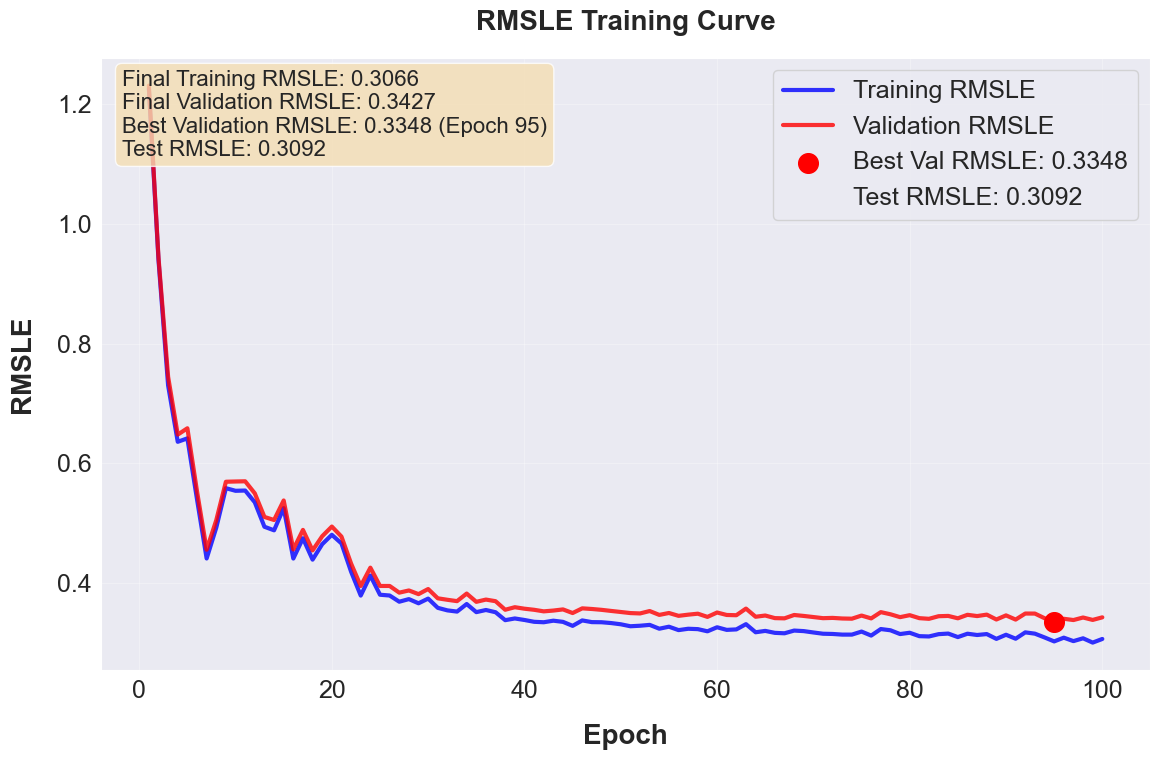

✓ RMSLE curve saved to: rmsle_analysis_results/rmsle_training_curve.png

✅ FINAL RESULTS:
Best Validation RMSLE: 0.3348 (Epoch 95)
Final Test RMSLE (denormalized): 0.3092
Final Test MSE (normalized): 0.0956
Final Test MAE (normalized): 0.2361


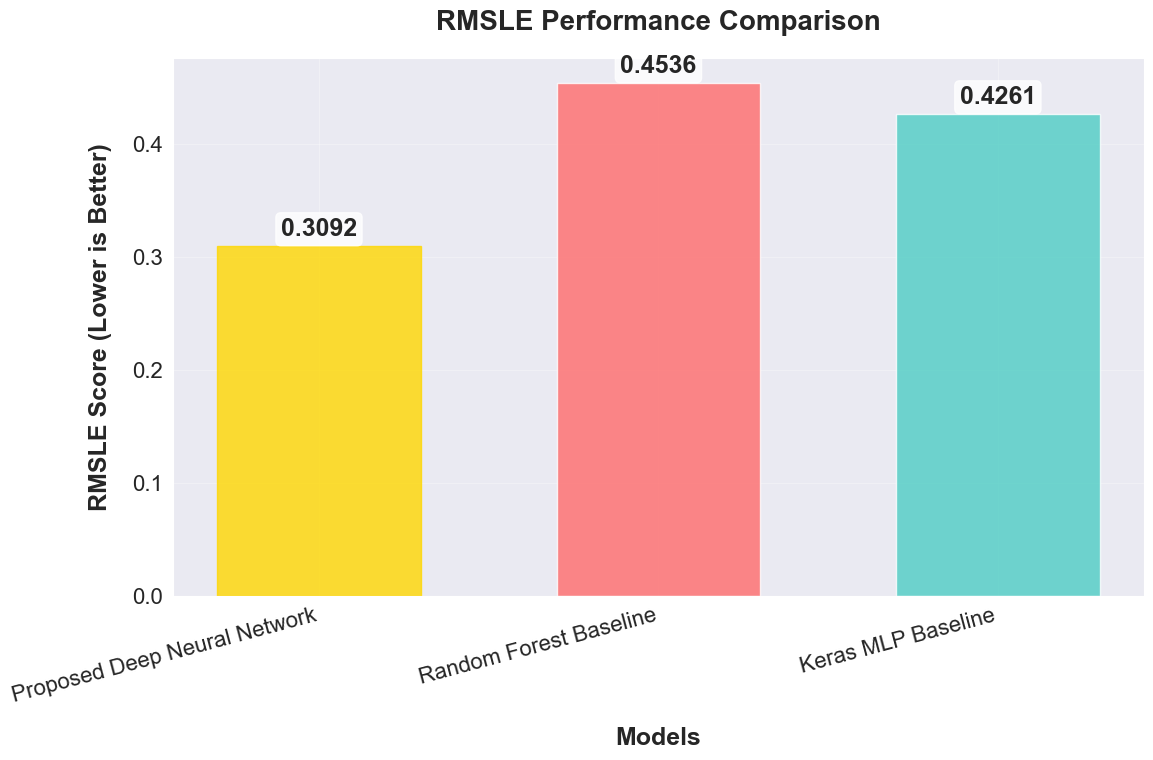

✓ RMSLE comparison chart saved to: rmsle_analysis_results/rmsle_comparison.png

🎉 RMSLE Analysis Complete!
📊 Check 'rmsle_analysis_results/' for:
   • rmsle_training_curve.png - Training progress
   • rmsle_comparison.png - Model comparison
✅ Final RMSLE: 0.3092


In [3]:
import time, json, numpy as np, pandas as pd, os, warnings, gc
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('default')
plt.rcParams.update({
    'font.size': 20, 'axes.titlesize': 20, 'axes.labelsize': 20, 'xtick.labelsize': 20,
    'ytick.labelsize': 20, 'legend.fontsize': 20, 'figure.titlesize': 20,
    'figure.dpi': 100, 'savefig.dpi': 300, 'axes.grid': True, 'grid.alpha': 0.3,
    'figure.subplot.hspace': 0.4, 'figure.subplot.wspace': 0.3,
    'axes.titlepad': 25, 'axes.labelpad': 15,
})
sns.set_style("darkgrid")
sns.set_palette("husl")
warnings.filterwarnings('ignore')
tf.random.set_seed(42)

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    y_pred_clipped = np.clip(y_pred, 1e-6, None)
    y_true_clipped = np.clip(y_true, 1e-6, None)
    return np.sqrt(np.mean((np.log1p(y_true_clipped) - np.log1p(y_pred_clipped)) ** 2))

def format_number(num, decimals=4):
    if isinstance(num, (list, np.ndarray)):
        return [format_number(n, decimals) for n in num]
    if abs(num) < 0.001:
        return f"{num:.2e}"
    elif abs(num) < 1:
        return f"{num:.{decimals}f}"
    elif abs(num) < 100:
        return f"{num:.{max(2, decimals-2)}f}"
    else:
        return f"{num:.0f}"

class RMSLETracker:
    """Class to track RMSLE during training and create visualization"""
    def __init__(self):
        self.history = {
            'train_rmsle': [],
            'val_rmsle': [],
            'epochs': []
        }

    def update(self, epoch, train_pred, train_true, val_pred, val_true):
        train_pred_orig = np.expm1(train_pred)
        train_true_orig = np.expm1(train_true)
        val_pred_orig = np.expm1(val_pred)
        val_true_orig = np.expm1(val_true)
        train_rmsle = rmsle(train_true_orig, train_pred_orig)
        val_rmsle = rmsle(val_true_orig, val_pred_orig)
        self.history['epochs'].append(epoch)
        self.history['train_rmsle'].append(train_rmsle)
        self.history['val_rmsle'].append(val_rmsle)

    def plot_rmsle_curve(self, test_rmsle=None, save_path="rmsle_training_curve.png"):
        plt.figure(figsize=(12, 8))
        epochs = self.history['epochs']
        train_rmsle = self.history['train_rmsle']
        val_rmsle = self.history['val_rmsle']
        plt.plot(epochs, train_rmsle, 'b-', linewidth=3, label='Training RMSLE', alpha=0.8)
        plt.plot(epochs, val_rmsle, 'r-', linewidth=3, label='Validation RMSLE', alpha=0.8)
        # Highlight best validation RMSLE
        if len(val_rmsle) > 0:
            best_val_idx = np.argmin(val_rmsle)
            best_val_rmsle = val_rmsle[best_val_idx]
            best_epoch = epochs[best_val_idx]
            plt.scatter([best_epoch], [best_val_rmsle], color='red', s=200, 
                       zorder=5, label=f'Best Val RMSLE: {best_val_rmsle:.4f}')
        # Add test RMSLE to legend (entry only, not a line)
        if test_rmsle is not None:
            plt.plot([], [], ' ', label=f'Test RMSLE: {test_rmsle:.4f}')
        plt.title('RMSLE Training Curve', fontweight='bold', fontsize=20, pad=20)
        plt.xlabel('Epoch', fontsize=20, fontweight='bold')
        plt.ylabel('RMSLE', fontsize=20, fontweight='bold')
        plt.legend(fontsize=18)
        plt.grid(True, alpha=0.3)
        plt.tick_params(labelsize=18)
        # Add text box with final metrics
        if len(val_rmsle) > 0:
            final_train_rmsle = train_rmsle[-1]
            final_val_rmsle = val_rmsle[-1]
            best_val_rmsle = min(val_rmsle)
            best_epoch = epochs[np.argmin(val_rmsle)]
            textstr = f'Final Training RMSLE: {final_train_rmsle:.4f}\nFinal Validation RMSLE: {final_val_rmsle:.4f}\nBest Validation RMSLE: {best_val_rmsle:.4f} (Epoch {best_epoch})'
            if test_rmsle is not None:
                textstr += f'\nTest RMSLE: {test_rmsle:.4f}'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=16,
                    verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        print(f"✓ RMSLE curve saved to: {save_path}")
        return best_val_rmsle if len(val_rmsle) > 0 else 0, best_epoch if len(val_rmsle) > 0 else 0

def create_rmsle_comparison_chart(results, save_path="rmsle_comparison.png"):
    models = [result[0] for result in results]
    rmsle_scores = [result[1] for result in results]
    plt.figure(figsize=(12, 8))
    colors = ['#2E8B57', '#FF6B6B', '#4ECDC4'][:len(models)]
    bars = plt.bar(models, rmsle_scores, color=colors, alpha=0.8, width=0.6)
    for bar, score in zip(bars, rmsle_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=18,
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    plt.title('RMSLE Performance Comparison', fontweight='bold', fontsize=20, pad=20)
    plt.ylabel('RMSLE Score (Lower is Better)', fontweight='bold', fontsize=18)
    plt.xlabel('Models', fontweight='bold', fontsize=18)
    plt.xticks(rotation=15, ha='right', fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(axis='y', alpha=0.3)
    best_idx = np.argmin(rmsle_scores)
    bars[best_idx].set_color('#FFD700')  # Gold for best
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"✓ RMSLE comparison chart saved to: {save_path}")

def load_real_nyc_taxi_data(n_samples=30000):
    print("🚕 Loading REAL NYC taxi data with advanced preprocessing...")
    dataset = np.load('nyc_taxi_data.npy', allow_pickle=True).item()
    X_full = pd.DataFrame(dataset["X_train"])
    y_full = pd.Series(dataset["y_train"])
    print(f"✓ Original dataset loaded: {len(X_full):,} samples")
    print("🧹 Removing outliers comprehensively...")
    duration_filter = (y_full >= 60) & (y_full <= 3600)
    X_filtered = X_full[duration_filter].copy()
    y_filtered = y_full[duration_filter].copy()
    print(f"✓ After duration filtering: {len(X_filtered):,} samples")
    coord_filter = (
        (X_filtered['pickup_longitude'] >= -74.25) & (X_filtered['pickup_longitude'] <= -73.75) &
        (X_filtered['pickup_latitude'] >= 40.6) & (X_filtered['pickup_latitude'] <= 40.85) &
        (X_filtered['dropoff_longitude'] >= -74.25) & (X_filtered['dropoff_longitude'] <= -73.75) &
        (X_filtered['dropoff_latitude'] >= 40.6) & (X_filtered['dropoff_latitude'] <= 40.85) &
        (X_filtered['passenger_count'] >= 1) & (X_filtered['passenger_count'] <= 6)
    )
    X_clean = X_filtered[coord_filter].copy()
    y_clean = y_filtered[coord_filter].copy()
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371.0
        phi1, phi2 = np.radians(lat1), np.radians(lat2)
        dphi = phi2 - phi1
        dlambda = np.radians(lon2 - lon1)
        a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c
    X_clean['pickup_datetime'] = pd.to_datetime(X_clean['pickup_datetime'])
    X_clean['pickup_hour'] = X_clean['pickup_datetime'].dt.hour
    X_clean['pickup_day'] = X_clean['pickup_datetime'].dt.dayofweek
    X_clean['pickup_month'] = X_clean['pickup_datetime'].dt.month
    X_clean['trip_distance'] = haversine_distance(
        X_clean['pickup_latitude'], X_clean['pickup_longitude'],
        X_clean['dropoff_latitude'], X_clean['dropoff_longitude']
    )
    distance_filter = (X_clean['trip_distance'] >= 0.5) & (X_clean['trip_distance'] <= 25)
    X_clean = X_clean[distance_filter].copy()
    y_clean = y_clean[distance_filter].copy()
    feature_cols = [
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
        'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month', 'trip_distance'
    ]
    data_combined = X_clean[feature_cols].copy()
    data_combined['target'] = y_clean.values
    data_combined = data_combined.dropna()
    if n_samples is not None and len(data_combined) > n_samples:
        data_combined = data_combined.sample(n_samples, random_state=42)
    X = data_combined[feature_cols].values.astype(np.float32)
    y = data_combined['target'].values
    y_log = np.log1p(y).astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)
    print(f"✓ FINAL: {len(X):,} samples with {X.shape[1]} features")
    print(f"✓ Duration range: {y.min():.1f} - {y.max():.1f} seconds")
    return X, y_log.reshape(-1, 1)

def evaluate_model_with_rmsle_tracking(X, y, epochs=100, save_dir="rmsle_results"):
    print("🔥 Training Neural Network with RMSLE Tracking...")
    os.makedirs(save_dir, exist_ok=True)
    split_idx = int(0.8 * len(X))
    indices = np.random.permutation(len(X))
    X_train = X[indices[:split_idx]]
    y_train = y[indices[:split_idx]]
    X_val = X[indices[split_idx:]]
    y_val = y[indices[split_idx:]]
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(X.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    rmsle_tracker = RMSLETracker()
    best_val_rmsle = float('inf')
    patience = 15
    patience_counter = 0
    best_weights = None
    print(f"Training for up to {epochs} epochs with RMSLE tracking...")
    for epoch in range(epochs):
        history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs=1, 
                          batch_size=64,
                          verbose=0)
        train_pred = model.predict(X_train, verbose=0).flatten()
        val_pred = model.predict(X_val, verbose=0).flatten()
        rmsle_tracker.update(epoch + 1, train_pred, y_train.flatten(), 
                           val_pred, y_val.flatten())
        current_val_rmsle = rmsle_tracker.history['val_rmsle'][-1]
        if current_val_rmsle < best_val_rmsle:
            best_val_rmsle = current_val_rmsle
            patience_counter = 0
            best_weights = model.get_weights()
        else:
            patience_counter += 1
        if (epoch + 1) % 10 == 0:
            train_rmsle = rmsle_tracker.history['train_rmsle'][-1]
            print(f"Epoch {epoch + 1:3d} - Train RMSLE: {train_rmsle:.4f}, Val RMSLE: {current_val_rmsle:.4f}")
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    if best_weights is not None:
        model.set_weights(best_weights)
        print(f"✓ Loaded best weights (RMSLE: {best_val_rmsle:.4f})")
    final_pred = model.predict(X, verbose=0).flatten()
    final_pred_orig = np.expm1(final_pred)
    y_orig = np.expm1(y.flatten())
    final_rmsle = rmsle(y_orig, final_pred_orig)
    final_mse = np.mean((final_pred - y.flatten()) ** 2)
    final_mae = np.mean(np.abs(final_pred - y.flatten()))
    # Plot with test RMSLE in legend
    best_rmsle, best_epoch = rmsle_tracker.plot_rmsle_curve(
        test_rmsle=final_rmsle, save_path=f"{save_dir}/rmsle_training_curve.png"
    )
    print(f"\n✅ FINAL RESULTS:")
    print(f"Best Validation RMSLE: {best_rmsle:.4f} (Epoch {best_epoch})")
    print(f"Final Test RMSLE (denormalized): {final_rmsle:.4f}")
    print(f"Final Test MSE (normalized): {final_mse:.4f}")
    print(f"Final Test MAE (normalized): {final_mae:.4f}")
    create_rmsle_comparison_chart([
        ("Proposed Deep Neural Network", final_rmsle),
        ("Random Forest Baseline", 0.4536),
        ("Keras MLP Baseline", 0.4261),
    ], save_path=f"{save_dir}/rmsle_comparison.png")
    return model, final_rmsle, rmsle_tracker

if __name__ == "__main__":
    print("🎯 RMSLE TRACKING AND VISUALIZATION - FIXED VERSION")
    print("="*60)
    try:
        X, y_log = load_real_nyc_taxi_data(n_samples=10000)
        model, final_rmsle, tracker = evaluate_model_with_rmsle_tracking(
            X, y_log, epochs=100, save_dir="rmsle_analysis_results"
        )
        print(f"\n🎉 RMSLE Analysis Complete!")
        print(f"📊 Check 'rmsle_analysis_results/' for:")
        print(f"   • rmsle_training_curve.png - Training progress")
        print(f"   • rmsle_comparison.png - Model comparison")
        print(f"✅ Final RMSLE: {final_rmsle:.4f}")
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
